In [65]:
import os
import argparse
import pandas as pd
import numpy as np
import xgboost as xgb
from math import ceil
from math import sqrt
from math import acos
from operator import itemgetter
from itertools import product
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import gc
import seaborn as sns
from scipy import stats
from collections import defaultdict
from tqdm import tqdm
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe , space_eval
import time

In [3]:
def load_data(vector_filename, ion_type):
    # Read file
    if vector_filename.split(".")[-1] == "pkl":
        vectors = pd.read_pickle(vector_filename)
    elif vector_filename.split(".")[-1] == "h5":
        # vectors = pd.read_hdf(vector_filename, key='table', stop=1000)
        vectors = pd.read_hdf(vector_filename, key="table")
    else:
        print("Unsuported feature vector format")
        exit(1)

    # Extract targets for given ion type
    target_names = list(vectors.columns[vectors.columns.str.contains("targets")])
    if not "targets_{}".format(ion_type) in target_names:
        print("Targets for {} could not be found in vector file.".format(ion_type))
        print("Vector file only contains these targets: {}".format(target_names))
        exit(1)

    targets = vectors.pop("targets_{}".format(ion_type))
    target_names.remove("targets_{}".format(ion_type))
    for n in target_names:
        vectors.pop(n)

    # Get psmids
    psmids = vectors.pop("psmid")

    return (vectors, targets, psmids)

In [4]:
def get_params_combinations(params):
    keys, values = zip(*params.items())
    combinations = [dict(zip(keys, v)) for v in product(*values)]
    return(combinations)

In [5]:
def get_best_params(df, params_grid):
    params = {}
    best = df[df['test-rmse-mean'] == df['test-rmse-mean'].min()]
    best_rmse = df['test-rmse-mean'].min()
    for p in params_grid.keys():
        params[p] = best[p].iloc[0]
    # num_boost_round = best['boosting-round'].iloc[0]
    return(params, best_rmse)

In [6]:
def gridsearch(xtrain, params, params_grid):
    cols = ['boosting-round', 'test-rmse-mean', 'test-rmse-std', 'train-rmse-mean', 'train-rmse-std']
    cols.extend(sorted(params_grid.keys()))
    result = pd.DataFrame(columns=cols)

    count = 1
    combinations = get_params_combinations(params_grid)

    for param_overrides in combinations:
        print("Working on combination {}/{}".format(count, len(combinations)))
        count += 1
        params.update(param_overrides)
        tmp = xgb.cv(params, xtrain, nfold=5, num_boost_round=200, early_stopping_rounds=10, verbose_eval=10)
        tmp['boosting-round'] = tmp.index
        for param in param_overrides.keys():
            tmp[param] = param_overrides[param]
        result = result.append(tmp)

    print("Grid search ready!\n")

    return(result)

In [7]:
def ms2pip_pearson(true, pred):
    """
    Return pearson of tic-normalized, log-transformed intensities, 
    the MS2PIP way.
    """
    #tic_norm = lambda x: x / np.sum(x)
    # log_transform = lambda x: np.log2(x + 0.001)
    corr = pearsonr(
        true, 
        pred
    )[0]
    return (corr)

In [8]:
def spectral_angle(true, pred, epsilon=1e-7):
    """
    Return square root normalized spectral angle.
    See https://doi.org/10.1074/mcp.O113.036475
    """
    
    de_log = lambda x: (2**x)-0.001
    l2_normalize = lambda x: x / sqrt(max(sum(x**2), epsilon))
    
    pred_norm = l2_normalize(de_log(pred))
    true_norm = l2_normalize(de_log(true))
    
    spectral_angle = 1 - (2 * acos(np.dot(pred_norm, true_norm)) / np.pi)

    return (spectral_angle)

# New scoring method

In [9]:
class Scorer:
    def __init__(self,psmids):
        self.psmids = psmids
        
    def psm_score(self,targets, predictions):
        tmp = pd.DataFrame(columns=["psmids", "targets", "predictions"])
        tmp["psmids"] = np.array(self.psmids)
        tmp["targets"] = np.array(targets)
        tmp["predictions"] = np.array(predictions)
        tmp2 = tmp.groupby("psmids").agg({'predictions': list, 'targets': list}).reset_index()
        spectral_corr = []
        pearson_corr = []
        for spectra in range(0, len(tmp2["psmids"])):
            spectral_corr.append(spectral_angle(np.array(tmp2.targets.loc[spectra]), np.array(tmp2.predictions.loc[spectra])))
            pearson_corr.append(ms2pip_pearson(np.array(tmp2.targets.loc[spectra]), np.array(tmp2.predictions.loc[spectra])))
        return (pearson_corr, spectral_corr) 

# Hyperparameter optimization b ions

In [10]:
vectors, targets, psmids = load_data("data/training_vector.pkl", "B")

In [11]:
upeps = psmids.unique()
np.random.shuffle(upeps)
test_psms = upeps[:int(len(upeps) * 0.1)]

train_vectors = vectors[~psmids.isin(test_psms)]
train_targets = targets[~psmids.isin(test_psms)]
train_psmids = psmids[~psmids.isin(test_psms)]

test_vectors = vectors[psmids.isin(test_psms)]
test_targets = targets[psmids.isin(test_psms)]
test_psmids = psmids[psmids.isin(test_psms)]

In [12]:
xtrain = xgb.DMatrix(train_vectors, label=train_targets)
xtest = xgb.DMatrix(test_vectors, label=test_targets)
evallist = [(xtrain, 'train'),(xtest, 'test')]

In [13]:
space= {
    'eta': hp.loguniform('eta', np.log(0.01), np.log(1)),
    'max_depth': hp.quniform('max_depth', 3, 18, 1),
    'max_leaves': hp.quniform('max_leaves', 5, 500, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'gamma' : hp.uniform ('gamma', 0.0,1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 500, 1),
    'subsample': hp.quniform('subsample', 0.5, 1 ,0.1),
    'reg_alpha': hp.quniform('reg_alpha', 0, 5 ,0.1)
}

In [14]:
def objective(space):
    params = {
    "nthread": 64,
    "objective": "reg:squarederror",
    "eval_metric": 'rmse',
    "eta": space["eta"],
    "max_depth": int(space['max_depth']),
    "grow_policy":"lossguide",
    "max_leaves":int(space["max_leaves"]),
    "min_child_weight": int(space["min_child_weight"]),
    "gamma": space['gamma'],
    "reg_lambda" : space['reg_lambda'],
    "colsample_bytree": space['colsample_bytree'],
    "subsample" : space["subsample"],
    "reg_alpha" : space["reg_alpha"]
    }
    print(params)
    tmp = xgb.cv(params, xtrain, nfold=4, num_boost_round=400, early_stopping_rounds=10, verbose_eval=True)
    rmse = tmp['test-rmse-mean'].min()

    print ("rmse:", rmse)
    return {'loss': rmse, 'status': STATUS_OK, "params": params}

In [15]:
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 25,
                        trials = trials)


best_hyperparams

{'nthread': 64, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.23979592162550495, 'max_depth': 15, 'grow_policy': 'lossguide', 'max_leaves': 397, 'min_child_weight': 264, 'gamma': 0.5504162624266153, 'reg_lambda': 0.7003799854022829, 'colsample_bytree': 0.8198669323995477, 'subsample': 0.6000000000000001, 'reg_alpha': 0.30000000000000004}
[0]	train-rmse:7.16312+0.00031	test-rmse:7.16341+0.00115

[1]	train-rmse:5.48590+0.00081	test-rmse:5.48638+0.00178

[2]	train-rmse:4.21977+0.00086	test-rmse:4.22059+0.00168

[3]	train-rmse:3.26877+0.00114	test-rmse:3.27013+0.00137

[4]	train-rmse:2.55929+0.00031	test-rmse:2.56157+0.00087

[5]	train-rmse:2.03472+0.00018	test-rmse:2.03804+0.00118

[6]	train-rmse:1.65534+0.00038	test-rmse:1.65988+0.00070

[7]	train-rmse:1.38653+0.00039	test-rmse:1.39267+0.00101

[8]	train-rmse:1.19981+0.00059	test-rmse:1.20778+0.00070

[9]	train-rmse:1.07439+0.00067	test-rmse:1.08409+0.00143

[10]	train-rmse:0.99163+0.00080	test-rmse:1.00305+0.00166

[1

[268]	train-rmse:0.67553+0.00075	test-rmse:0.78701+0.00117

[269]	train-rmse:0.67524+0.00074	test-rmse:0.78700+0.00118

[270]	train-rmse:0.67490+0.00082	test-rmse:0.78694+0.00118

[271]	train-rmse:0.67467+0.00077	test-rmse:0.78691+0.00119

[272]	train-rmse:0.67434+0.00086	test-rmse:0.78687+0.00121

[273]	train-rmse:0.67401+0.00088	test-rmse:0.78682+0.00121

[274]	train-rmse:0.67369+0.00091	test-rmse:0.78679+0.00121

[275]	train-rmse:0.67341+0.00093	test-rmse:0.78677+0.00120

[276]	train-rmse:0.67306+0.00096	test-rmse:0.78674+0.00121

[277]	train-rmse:0.67270+0.00104	test-rmse:0.78670+0.00123

[278]	train-rmse:0.67236+0.00106	test-rmse:0.78666+0.00125

[279]	train-rmse:0.67207+0.00116	test-rmse:0.78664+0.00124

[280]	train-rmse:0.67178+0.00111	test-rmse:0.78662+0.00124

[281]	train-rmse:0.67148+0.00116	test-rmse:0.78659+0.00124

[282]	train-rmse:0.67124+0.00119	test-rmse:0.78657+0.00124

[283]	train-rmse:0.67095+0.00116	test-rmse:0.78653+0.00124

[284]	train-rmse:0.67070+0.00112	test-rm

[0]	train-rmse:8.99567+0.00034	test-rmse:8.99585+0.00121                               

[1]	train-rmse:8.63120+0.00022	test-rmse:8.63140+0.00135                               

[2]	train-rmse:8.28233+0.00015	test-rmse:8.28233+0.00145                               

[3]	train-rmse:7.94806+0.00016	test-rmse:7.94799+0.00138                               

[4]	train-rmse:7.62767+0.00011	test-rmse:7.62761+0.00143                               

[5]	train-rmse:7.32060+0.00003	test-rmse:7.32066+0.00134                               

[6]	train-rmse:7.02661+0.00014	test-rmse:7.02665+0.00147                               

[7]	train-rmse:6.74536+0.00022	test-rmse:6.74534+0.00154                               

[8]	train-rmse:6.47549+0.00018	test-rmse:6.47557+0.00131                               

[9]	train-rmse:6.21721+0.00019	test-rmse:6.21731+0.00127                               

[10]	train-rmse:5.97000+0.00020	test-rmse:5.97002+0.00132                              

[11]	train-rmse:5.733

[184]	train-rmse:0.92040+0.00072	test-rmse:0.92356+0.00129                             

[185]	train-rmse:0.91976+0.00078	test-rmse:0.92293+0.00135                             

[186]	train-rmse:0.91935+0.00074	test-rmse:0.92255+0.00132                             

[187]	train-rmse:0.91892+0.00078	test-rmse:0.92213+0.00137                             

[188]	train-rmse:0.91836+0.00074	test-rmse:0.92158+0.00133                             

[189]	train-rmse:0.91787+0.00076	test-rmse:0.92111+0.00138                             

[190]	train-rmse:0.91734+0.00073	test-rmse:0.92061+0.00134                             

[191]	train-rmse:0.91679+0.00075	test-rmse:0.92007+0.00134                             

[192]	train-rmse:0.91630+0.00071	test-rmse:0.91959+0.00132                             

[193]	train-rmse:0.91582+0.00073	test-rmse:0.91914+0.00134                             

[194]	train-rmse:0.91532+0.00068	test-rmse:0.91865+0.00126                             

[195]	train-rmse:0.91

[368]	train-rmse:0.87096+0.00059	test-rmse:0.87675+0.00095                             

[369]	train-rmse:0.87081+0.00062	test-rmse:0.87660+0.00096                             

[370]	train-rmse:0.87069+0.00063	test-rmse:0.87649+0.00096                             

[371]	train-rmse:0.87052+0.00065	test-rmse:0.87634+0.00099                             

[372]	train-rmse:0.87037+0.00068	test-rmse:0.87620+0.00103                             

[373]	train-rmse:0.87015+0.00061	test-rmse:0.87600+0.00098                             

[374]	train-rmse:0.87006+0.00059	test-rmse:0.87592+0.00099                             

[375]	train-rmse:0.86990+0.00060	test-rmse:0.87577+0.00097                             

[376]	train-rmse:0.86975+0.00059	test-rmse:0.87563+0.00098                             

[377]	train-rmse:0.86956+0.00054	test-rmse:0.87545+0.00092                             

[378]	train-rmse:0.86942+0.00053	test-rmse:0.87533+0.00093                             

[379]	train-rmse:0.86

[146]	train-rmse:0.91173+0.00037	test-rmse:0.92174+0.00078                             

[147]	train-rmse:0.90924+0.00045	test-rmse:0.91933+0.00080                             

[148]	train-rmse:0.90686+0.00046	test-rmse:0.91704+0.00085                             

[149]	train-rmse:0.90464+0.00043	test-rmse:0.91490+0.00085                             

[150]	train-rmse:0.90246+0.00042	test-rmse:0.91280+0.00086                             

[151]	train-rmse:0.90043+0.00043	test-rmse:0.91084+0.00086                             

[152]	train-rmse:0.89847+0.00042	test-rmse:0.90895+0.00080                             

[153]	train-rmse:0.89653+0.00041	test-rmse:0.90710+0.00081                             

[154]	train-rmse:0.89451+0.00041	test-rmse:0.90516+0.00086                             

[155]	train-rmse:0.89257+0.00033	test-rmse:0.90331+0.00080                             

[156]	train-rmse:0.89083+0.00031	test-rmse:0.90164+0.00081                             

[157]	train-rmse:0.88

[330]	train-rmse:0.79986+0.00049	test-rmse:0.82193+0.00076                             

[331]	train-rmse:0.79965+0.00052	test-rmse:0.82177+0.00078                             

[332]	train-rmse:0.79943+0.00053	test-rmse:0.82162+0.00079                             

[333]	train-rmse:0.79922+0.00051	test-rmse:0.82146+0.00078                             

[334]	train-rmse:0.79898+0.00048	test-rmse:0.82129+0.00078                             

[335]	train-rmse:0.79877+0.00050	test-rmse:0.82113+0.00080                             

[336]	train-rmse:0.79855+0.00050	test-rmse:0.82097+0.00078                             

[337]	train-rmse:0.79833+0.00047	test-rmse:0.82081+0.00078                             

[338]	train-rmse:0.79814+0.00048	test-rmse:0.82068+0.00078                             

[339]	train-rmse:0.79792+0.00048	test-rmse:0.82051+0.00080                             

[340]	train-rmse:0.79774+0.00048	test-rmse:0.82038+0.00080                             

[341]	train-rmse:0.79

[108]	train-rmse:1.33082+0.00111	test-rmse:1.33091+0.00145                             

[109]	train-rmse:1.32516+0.00119	test-rmse:1.32525+0.00157                             

[110]	train-rmse:1.31951+0.00125	test-rmse:1.31960+0.00155                             

[111]	train-rmse:1.31435+0.00129	test-rmse:1.31444+0.00160                             

[112]	train-rmse:1.30920+0.00108	test-rmse:1.30929+0.00147                             

[113]	train-rmse:1.30429+0.00114	test-rmse:1.30439+0.00152                             

[114]	train-rmse:1.29952+0.00130	test-rmse:1.29963+0.00170                             

[115]	train-rmse:1.29503+0.00129	test-rmse:1.29515+0.00165                             

[116]	train-rmse:1.29085+0.00121	test-rmse:1.29096+0.00155                             

[117]	train-rmse:1.28671+0.00120	test-rmse:1.28683+0.00159                             

[118]	train-rmse:1.28279+0.00124	test-rmse:1.28289+0.00167                             

[119]	train-rmse:1.27

[292]	train-rmse:1.11780+0.00094	test-rmse:1.11805+0.00081                             

[293]	train-rmse:1.11747+0.00100	test-rmse:1.11772+0.00085                             

[294]	train-rmse:1.11715+0.00104	test-rmse:1.11740+0.00090                             

[295]	train-rmse:1.11680+0.00106	test-rmse:1.11705+0.00092                             

[296]	train-rmse:1.11653+0.00106	test-rmse:1.11679+0.00092                             

[297]	train-rmse:1.11615+0.00102	test-rmse:1.11641+0.00089                             

[298]	train-rmse:1.11581+0.00095	test-rmse:1.11607+0.00081                             

[299]	train-rmse:1.11556+0.00098	test-rmse:1.11581+0.00084                             

[300]	train-rmse:1.11524+0.00101	test-rmse:1.11550+0.00090                             

[301]	train-rmse:1.11487+0.00102	test-rmse:1.11513+0.00089                             

[302]	train-rmse:1.11452+0.00097	test-rmse:1.11478+0.00084                             

[303]	train-rmse:1.11

[70]	train-rmse:3.15710+0.00020	test-rmse:3.15773+0.00091                              

[71]	train-rmse:3.11195+0.00015	test-rmse:3.11259+0.00096                              

[72]	train-rmse:3.06753+0.00014	test-rmse:3.06818+0.00095                              

[73]	train-rmse:3.02387+0.00012	test-rmse:3.02457+0.00095                              

[74]	train-rmse:2.98103+0.00014	test-rmse:2.98173+0.00094                              

[75]	train-rmse:2.93888+0.00018	test-rmse:2.93960+0.00091                              

[76]	train-rmse:2.89752+0.00017	test-rmse:2.89828+0.00090                              

[77]	train-rmse:2.85687+0.00016	test-rmse:2.85763+0.00093                              

[78]	train-rmse:2.81693+0.00014	test-rmse:2.81771+0.00093                              

[79]	train-rmse:2.77771+0.00015	test-rmse:2.77851+0.00093                              

[80]	train-rmse:2.73914+0.00014	test-rmse:2.73997+0.00095                              

[81]	train-rmse:2.701

[254]	train-rmse:0.90934+0.00063	test-rmse:0.91564+0.00065                             

[255]	train-rmse:0.90857+0.00065	test-rmse:0.91489+0.00066                             

[256]	train-rmse:0.90779+0.00063	test-rmse:0.91414+0.00063                             

[257]	train-rmse:0.90695+0.00065	test-rmse:0.91333+0.00063                             

[258]	train-rmse:0.90614+0.00064	test-rmse:0.91255+0.00063                             

[259]	train-rmse:0.90535+0.00062	test-rmse:0.91178+0.00055                             

[260]	train-rmse:0.90463+0.00061	test-rmse:0.91108+0.00060                             

[261]	train-rmse:0.90396+0.00062	test-rmse:0.91044+0.00059                             

[262]	train-rmse:0.90322+0.00062	test-rmse:0.90972+0.00056                             

[263]	train-rmse:0.90249+0.00060	test-rmse:0.90902+0.00060                             

[264]	train-rmse:0.90173+0.00062	test-rmse:0.90828+0.00063                             

[265]	train-rmse:0.90

[32]	train-rmse:1.04103+0.00305	test-rmse:1.04238+0.00237                              

[33]	train-rmse:1.03902+0.00357	test-rmse:1.04037+0.00277                              

[34]	train-rmse:1.03655+0.00378	test-rmse:1.03797+0.00291                              

[35]	train-rmse:1.03489+0.00360	test-rmse:1.03631+0.00276                              

[36]	train-rmse:1.03286+0.00366	test-rmse:1.03425+0.00273                              

[37]	train-rmse:1.03135+0.00379	test-rmse:1.03281+0.00289                              

[38]	train-rmse:1.02885+0.00287	test-rmse:1.03048+0.00212                              

[39]	train-rmse:1.02655+0.00265	test-rmse:1.02821+0.00189                              

[40]	train-rmse:1.02493+0.00245	test-rmse:1.02666+0.00170                              

[41]	train-rmse:1.02290+0.00170	test-rmse:1.02462+0.00094                              

[42]	train-rmse:1.02137+0.00174	test-rmse:1.02312+0.00107                              

[43]	train-rmse:1.019

[216]	train-rmse:0.92527+0.00030	test-rmse:0.93270+0.00122                             

[217]	train-rmse:0.92506+0.00031	test-rmse:0.93251+0.00122                             

[218]	train-rmse:0.92486+0.00039	test-rmse:0.93234+0.00131                             

[219]	train-rmse:0.92463+0.00044	test-rmse:0.93215+0.00135                             

[220]	train-rmse:0.92439+0.00043	test-rmse:0.93196+0.00136                             

[221]	train-rmse:0.92418+0.00039	test-rmse:0.93178+0.00136                             

[222]	train-rmse:0.92405+0.00038	test-rmse:0.93167+0.00133                             

[223]	train-rmse:0.92383+0.00036	test-rmse:0.93146+0.00133                             

[224]	train-rmse:0.92362+0.00041	test-rmse:0.93128+0.00138                             

[225]	train-rmse:0.92339+0.00039	test-rmse:0.93109+0.00136                             

[226]	train-rmse:0.92321+0.00038	test-rmse:0.93094+0.00135                             

[227]	train-rmse:0.92

rmse:                                                                                  
0.9066967499999999                                                                     
{'nthread': 64, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.07010476805725874, 'max_depth': 12, 'grow_policy': 'lossguide', 'max_leaves': 228, 'min_child_weight': 262, 'gamma': 0.9990756373781892, 'reg_lambda': 0.019816723750331167, 'colsample_bytree': 0.9094665293596391, 'subsample': 0.8, 'reg_alpha': 0.6000000000000001}
[0]	train-rmse:8.72798+0.00039	test-rmse:8.72803+0.00116                               

[1]	train-rmse:8.12604+0.00035	test-rmse:8.12588+0.00115                               

[2]	train-rmse:7.56640+0.00028	test-rmse:7.56652+0.00116                               

[3]	train-rmse:7.04682+0.00040	test-rmse:7.04703+0.00103                               

[4]	train-rmse:6.56437+0.00033	test-rmse:6.56455+0.00103                               

[5]	train-rmse:6.11629+0.00027	tes

[178]	train-rmse:0.77952+0.00060	test-rmse:0.80812+0.00084                             

[179]	train-rmse:0.77925+0.00054	test-rmse:0.80793+0.00083                             

[180]	train-rmse:0.77894+0.00044	test-rmse:0.80774+0.00081                             

[181]	train-rmse:0.77863+0.00045	test-rmse:0.80753+0.00079                             

[182]	train-rmse:0.77834+0.00049	test-rmse:0.80733+0.00082                             

[183]	train-rmse:0.77805+0.00049	test-rmse:0.80714+0.00078                             

[184]	train-rmse:0.77774+0.00043	test-rmse:0.80694+0.00077                             

[185]	train-rmse:0.77750+0.00042	test-rmse:0.80679+0.00079                             

[186]	train-rmse:0.77716+0.00044	test-rmse:0.80655+0.00076                             

[187]	train-rmse:0.77694+0.00044	test-rmse:0.80641+0.00074                             

[188]	train-rmse:0.77673+0.00041	test-rmse:0.80628+0.00068                             

[189]	train-rmse:0.77

[362]	train-rmse:0.74587+0.00025	test-rmse:0.78836+0.00076                             

[363]	train-rmse:0.74574+0.00021	test-rmse:0.78829+0.00076                             

[364]	train-rmse:0.74563+0.00022	test-rmse:0.78824+0.00075                             

[365]	train-rmse:0.74551+0.00021	test-rmse:0.78818+0.00076                             

[366]	train-rmse:0.74541+0.00017	test-rmse:0.78814+0.00076                             

[367]	train-rmse:0.74522+0.00017	test-rmse:0.78803+0.00080                             

[368]	train-rmse:0.74506+0.00018	test-rmse:0.78794+0.00078                             

[369]	train-rmse:0.74490+0.00020	test-rmse:0.78785+0.00077                             

[370]	train-rmse:0.74479+0.00024	test-rmse:0.78780+0.00075                             

[371]	train-rmse:0.74471+0.00022	test-rmse:0.78776+0.00076                             

[372]	train-rmse:0.74459+0.00022	test-rmse:0.78769+0.00076                             

[373]	train-rmse:0.74

[140]	train-rmse:0.90272+0.00285	test-rmse:0.91104+0.00221                             

[141]	train-rmse:0.90253+0.00282	test-rmse:0.91090+0.00217                             

[142]	train-rmse:0.90217+0.00268	test-rmse:0.91059+0.00202                             

[143]	train-rmse:0.90191+0.00268	test-rmse:0.91038+0.00201                             

[144]	train-rmse:0.90163+0.00268	test-rmse:0.91014+0.00202                             

[145]	train-rmse:0.90131+0.00251	test-rmse:0.90986+0.00187                             

[146]	train-rmse:0.90092+0.00244	test-rmse:0.90955+0.00181                             

[147]	train-rmse:0.90058+0.00231	test-rmse:0.90924+0.00169                             

[148]	train-rmse:0.90016+0.00225	test-rmse:0.90885+0.00165                             

[149]	train-rmse:0.89969+0.00222	test-rmse:0.90843+0.00165                             

[150]	train-rmse:0.89913+0.00209	test-rmse:0.90794+0.00155                             

[151]	train-rmse:0.89

[324]	train-rmse:0.86417+0.00188	test-rmse:0.88175+0.00124                             

[325]	train-rmse:0.86406+0.00185	test-rmse:0.88168+0.00123                             

[326]	train-rmse:0.86396+0.00187	test-rmse:0.88163+0.00125                             

[327]	train-rmse:0.86388+0.00184	test-rmse:0.88159+0.00122                             

[328]	train-rmse:0.86373+0.00182	test-rmse:0.88150+0.00119                             

[329]	train-rmse:0.86364+0.00179	test-rmse:0.88145+0.00117                             

[330]	train-rmse:0.86352+0.00176	test-rmse:0.88138+0.00113                             

[331]	train-rmse:0.86337+0.00171	test-rmse:0.88126+0.00108                             

[332]	train-rmse:0.86325+0.00166	test-rmse:0.88118+0.00105                             

[333]	train-rmse:0.86313+0.00167	test-rmse:0.88111+0.00105                             

[334]	train-rmse:0.86300+0.00169	test-rmse:0.88103+0.00107                             

[335]	train-rmse:0.86

[102]	train-rmse:0.61989+0.00064	test-rmse:0.76531+0.00058                             

[103]	train-rmse:0.61866+0.00070	test-rmse:0.76504+0.00059                             

[104]	train-rmse:0.61725+0.00064	test-rmse:0.76476+0.00060                             

[105]	train-rmse:0.61598+0.00062	test-rmse:0.76448+0.00055                             

[106]	train-rmse:0.61448+0.00067	test-rmse:0.76415+0.00057                             

[107]	train-rmse:0.61322+0.00068	test-rmse:0.76390+0.00055                             

[108]	train-rmse:0.61191+0.00072	test-rmse:0.76364+0.00054                             

[109]	train-rmse:0.61052+0.00059	test-rmse:0.76337+0.00050                             

[110]	train-rmse:0.60918+0.00066	test-rmse:0.76305+0.00054                             

[111]	train-rmse:0.60803+0.00075	test-rmse:0.76282+0.00056                             

[112]	train-rmse:0.60692+0.00084	test-rmse:0.76260+0.00058                             

[113]	train-rmse:0.60

[285]	train-rmse:0.48645+0.00069	test-rmse:0.74821+0.00074                              

[286]	train-rmse:0.48600+0.00070	test-rmse:0.74819+0.00073                              

[287]	train-rmse:0.48544+0.00075	test-rmse:0.74816+0.00073                              

[288]	train-rmse:0.48491+0.00078	test-rmse:0.74810+0.00073                              

[289]	train-rmse:0.48438+0.00082	test-rmse:0.74808+0.00073                              

[290]	train-rmse:0.48395+0.00086	test-rmse:0.74806+0.00073                              

[291]	train-rmse:0.48352+0.00084	test-rmse:0.74805+0.00074                              

[292]	train-rmse:0.48317+0.00087	test-rmse:0.74803+0.00074                              

[293]	train-rmse:0.48274+0.00083	test-rmse:0.74801+0.00074                              

[294]	train-rmse:0.48232+0.00073	test-rmse:0.74799+0.00076                              

[295]	train-rmse:0.48191+0.00068	test-rmse:0.74796+0.00076                              

[296]	trai

[61]	train-rmse:0.84511+0.00084	test-rmse:0.85684+0.00014                               

[62]	train-rmse:0.84402+0.00109	test-rmse:0.85587+0.00046                               

[63]	train-rmse:0.84307+0.00105	test-rmse:0.85508+0.00049                               

[64]	train-rmse:0.84214+0.00120	test-rmse:0.85428+0.00065                               

[65]	train-rmse:0.84125+0.00114	test-rmse:0.85355+0.00050                               

[66]	train-rmse:0.84037+0.00100	test-rmse:0.85280+0.00030                               

[67]	train-rmse:0.83962+0.00100	test-rmse:0.85218+0.00039                               

[68]	train-rmse:0.83871+0.00102	test-rmse:0.85139+0.00033                               

[69]	train-rmse:0.83794+0.00095	test-rmse:0.85076+0.00024                               

[70]	train-rmse:0.83720+0.00087	test-rmse:0.85019+0.00030                               

[71]	train-rmse:0.83651+0.00085	test-rmse:0.84962+0.00031                               

[72]	train

[243]	train-rmse:0.78014+0.00161	test-rmse:0.80944+0.00063                              

[244]	train-rmse:0.77997+0.00159	test-rmse:0.80935+0.00064                              

[245]	train-rmse:0.77983+0.00152	test-rmse:0.80926+0.00061                              

[246]	train-rmse:0.77969+0.00141	test-rmse:0.80918+0.00057                              

[247]	train-rmse:0.77952+0.00141	test-rmse:0.80907+0.00057                              

[248]	train-rmse:0.77936+0.00139	test-rmse:0.80900+0.00057                              

[249]	train-rmse:0.77918+0.00141	test-rmse:0.80890+0.00056                              

[250]	train-rmse:0.77903+0.00145	test-rmse:0.80882+0.00055                              

[251]	train-rmse:0.77889+0.00141	test-rmse:0.80876+0.00054                              

[252]	train-rmse:0.77873+0.00149	test-rmse:0.80864+0.00053                              

[253]	train-rmse:0.77846+0.00145	test-rmse:0.80846+0.00048                              

[254]	trai

[19]	train-rmse:0.87814+0.00114	test-rmse:0.92212+0.00174                                

[20]	train-rmse:0.87580+0.00128	test-rmse:0.92153+0.00188                                

[21]	train-rmse:0.87383+0.00168	test-rmse:0.92096+0.00203                                

[22]	train-rmse:0.87195+0.00155	test-rmse:0.92049+0.00194                                

[23]	train-rmse:0.87028+0.00156	test-rmse:0.92020+0.00189                                

[24]	train-rmse:0.86866+0.00139	test-rmse:0.92015+0.00192                                

[25]	train-rmse:0.86724+0.00137	test-rmse:0.92002+0.00194                                

[26]	train-rmse:0.86542+0.00157	test-rmse:0.91982+0.00172                                

[27]	train-rmse:0.86396+0.00148	test-rmse:0.91966+0.00153                                

[28]	train-rmse:0.86250+0.00177	test-rmse:0.91950+0.00138                                

[29]	train-rmse:0.86062+0.00145	test-rmse:0.91919+0.00128                                


[146]	train-rmse:0.97876+0.00298	test-rmse:0.98111+0.00266                               

[147]	train-rmse:0.97836+0.00292	test-rmse:0.98074+0.00260                               

[148]	train-rmse:0.97776+0.00303	test-rmse:0.98013+0.00264                               

[149]	train-rmse:0.97749+0.00306	test-rmse:0.97988+0.00267                               

[150]	train-rmse:0.97676+0.00305	test-rmse:0.97912+0.00260                               

[151]	train-rmse:0.97636+0.00305	test-rmse:0.97875+0.00258                               

[152]	train-rmse:0.97579+0.00298	test-rmse:0.97816+0.00252                               

[153]	train-rmse:0.97533+0.00297	test-rmse:0.97769+0.00252                               

[154]	train-rmse:0.97504+0.00295	test-rmse:0.97742+0.00249                               

[155]	train-rmse:0.97473+0.00296	test-rmse:0.97711+0.00249                               

[156]	train-rmse:0.97444+0.00298	test-rmse:0.97684+0.00252                               


[326]	train-rmse:0.93297+0.00165	test-rmse:0.93766+0.00114                               

[327]	train-rmse:0.93285+0.00163	test-rmse:0.93754+0.00112                               

[328]	train-rmse:0.93269+0.00164	test-rmse:0.93737+0.00111                               

[329]	train-rmse:0.93260+0.00166	test-rmse:0.93730+0.00114                               

[330]	train-rmse:0.93249+0.00168	test-rmse:0.93720+0.00116                               

[331]	train-rmse:0.93240+0.00168	test-rmse:0.93711+0.00116                               

[332]	train-rmse:0.93230+0.00167	test-rmse:0.93704+0.00116                               

[333]	train-rmse:0.93219+0.00169	test-rmse:0.93694+0.00118                               

[334]	train-rmse:0.93204+0.00172	test-rmse:0.93683+0.00117                               

[335]	train-rmse:0.93194+0.00175	test-rmse:0.93673+0.00119                               

[336]	train-rmse:0.93183+0.00177	test-rmse:0.93663+0.00123                               


[100]	train-rmse:0.90659+0.00106	test-rmse:0.91021+0.00161                               

[101]	train-rmse:0.90579+0.00098	test-rmse:0.90944+0.00154                               

[102]	train-rmse:0.90507+0.00109	test-rmse:0.90875+0.00167                               

[103]	train-rmse:0.90431+0.00104	test-rmse:0.90802+0.00164                               

[104]	train-rmse:0.90364+0.00105	test-rmse:0.90739+0.00164                               

[105]	train-rmse:0.90307+0.00108	test-rmse:0.90685+0.00167                               

[106]	train-rmse:0.90240+0.00104	test-rmse:0.90621+0.00160                               

[107]	train-rmse:0.90173+0.00093	test-rmse:0.90558+0.00146                               

[108]	train-rmse:0.90105+0.00084	test-rmse:0.90492+0.00136                               

[109]	train-rmse:0.90056+0.00089	test-rmse:0.90446+0.00143                               

[110]	train-rmse:0.90004+0.00096	test-rmse:0.90397+0.00150                               


[280]	train-rmse:0.84987+0.00040	test-rmse:0.85811+0.00060                               

[281]	train-rmse:0.84976+0.00040	test-rmse:0.85802+0.00059                               

[282]	train-rmse:0.84958+0.00039	test-rmse:0.85787+0.00064                               

[283]	train-rmse:0.84943+0.00040	test-rmse:0.85773+0.00065                               

[284]	train-rmse:0.84926+0.00045	test-rmse:0.85759+0.00068                               

[285]	train-rmse:0.84902+0.00025	test-rmse:0.85736+0.00063                               

[286]	train-rmse:0.84889+0.00026	test-rmse:0.85726+0.00066                               

[287]	train-rmse:0.84877+0.00026	test-rmse:0.85715+0.00070                               

[288]	train-rmse:0.84849+0.00030	test-rmse:0.85689+0.00067                               

[289]	train-rmse:0.84837+0.00025	test-rmse:0.85679+0.00067                               

[290]	train-rmse:0.84821+0.00023	test-rmse:0.85665+0.00060                               


[54]	train-rmse:1.01292+0.00084	test-rmse:1.01399+0.00080                               

[55]	train-rmse:1.01047+0.00123	test-rmse:1.01154+0.00104                               

[56]	train-rmse:1.00820+0.00131	test-rmse:1.00928+0.00110                               

[57]	train-rmse:1.00581+0.00150	test-rmse:1.00691+0.00121                               

[58]	train-rmse:1.00409+0.00162	test-rmse:1.00521+0.00135                               

[59]	train-rmse:1.00227+0.00106	test-rmse:1.00342+0.00086                               

[60]	train-rmse:0.99999+0.00130	test-rmse:1.00115+0.00104                               

[61]	train-rmse:0.99790+0.00128	test-rmse:0.99908+0.00096                               

[62]	train-rmse:0.99613+0.00127	test-rmse:0.99732+0.00088                               

[63]	train-rmse:0.99483+0.00146	test-rmse:0.99604+0.00104                               

[64]	train-rmse:0.99307+0.00153	test-rmse:0.99431+0.00106                               

[65]	train

[236]	train-rmse:0.89318+0.00027	test-rmse:0.89709+0.00073                              

[237]	train-rmse:0.89293+0.00027	test-rmse:0.89685+0.00075                              

[238]	train-rmse:0.89265+0.00032	test-rmse:0.89659+0.00082                              

[239]	train-rmse:0.89248+0.00038	test-rmse:0.89642+0.00086                              

[240]	train-rmse:0.89217+0.00039	test-rmse:0.89614+0.00090                              

[241]	train-rmse:0.89197+0.00037	test-rmse:0.89595+0.00089                              

[242]	train-rmse:0.89181+0.00039	test-rmse:0.89580+0.00091                              

[243]	train-rmse:0.89155+0.00035	test-rmse:0.89556+0.00088                              

[244]	train-rmse:0.89131+0.00031	test-rmse:0.89533+0.00086                              

[245]	train-rmse:0.89108+0.00040	test-rmse:0.89511+0.00092                              

[246]	train-rmse:0.89084+0.00046	test-rmse:0.89488+0.00096                              

[247]	trai

[12]	train-rmse:0.80128+0.00316	test-rmse:0.84278+0.00314                               

[13]	train-rmse:0.79543+0.00191	test-rmse:0.83928+0.00214                               

[14]	train-rmse:0.78990+0.00183	test-rmse:0.83616+0.00207                               

[15]	train-rmse:0.78517+0.00222	test-rmse:0.83398+0.00247                               

[16]	train-rmse:0.78040+0.00248	test-rmse:0.83135+0.00249                               

[17]	train-rmse:0.77645+0.00256	test-rmse:0.82968+0.00253                               

[18]	train-rmse:0.77279+0.00260	test-rmse:0.82810+0.00285                               

[19]	train-rmse:0.76918+0.00213	test-rmse:0.82660+0.00276                               

[20]	train-rmse:0.76570+0.00176	test-rmse:0.82505+0.00266                               

[21]	train-rmse:0.76296+0.00193	test-rmse:0.82409+0.00268                               

[22]	train-rmse:0.75982+0.00151	test-rmse:0.82284+0.00245                               

[23]	train

[34]	train-rmse:1.09656+0.00131	test-rmse:1.09691+0.00140                               

[35]	train-rmse:1.09342+0.00138	test-rmse:1.09380+0.00120                               

[36]	train-rmse:1.09001+0.00128	test-rmse:1.09038+0.00117                               

[37]	train-rmse:1.08732+0.00180	test-rmse:1.08770+0.00176                               

[38]	train-rmse:1.08504+0.00174	test-rmse:1.08543+0.00175                               

[39]	train-rmse:1.08237+0.00162	test-rmse:1.08275+0.00148                               

[40]	train-rmse:1.07991+0.00146	test-rmse:1.08030+0.00123                               

[41]	train-rmse:1.07725+0.00196	test-rmse:1.07766+0.00171                               

[42]	train-rmse:1.07459+0.00147	test-rmse:1.07501+0.00136                               

[43]	train-rmse:1.07171+0.00181	test-rmse:1.07210+0.00154                               

[44]	train-rmse:1.06967+0.00196	test-rmse:1.07007+0.00168                               

[45]	train

[216]	train-rmse:0.95194+0.00061	test-rmse:0.95365+0.00133                              

[217]	train-rmse:0.95148+0.00039	test-rmse:0.95319+0.00113                              

[218]	train-rmse:0.95126+0.00042	test-rmse:0.95298+0.00114                              

[219]	train-rmse:0.95097+0.00045	test-rmse:0.95270+0.00117                              

[220]	train-rmse:0.95061+0.00053	test-rmse:0.95234+0.00125                              

[221]	train-rmse:0.95030+0.00054	test-rmse:0.95204+0.00127                              

[222]	train-rmse:0.95009+0.00047	test-rmse:0.95183+0.00121                              

[223]	train-rmse:0.94987+0.00054	test-rmse:0.95161+0.00128                              

[224]	train-rmse:0.94951+0.00069	test-rmse:0.95126+0.00134                              

[225]	train-rmse:0.94931+0.00074	test-rmse:0.95107+0.00139                              

[226]	train-rmse:0.94908+0.00070	test-rmse:0.95085+0.00137                              

[227]	trai

[398]	train-rmse:0.91718+0.00076	test-rmse:0.92000+0.00116                              

[399]	train-rmse:0.91709+0.00079	test-rmse:0.91992+0.00118                              

rmse:                                                                                   
0.9199200000000001                                                                      
{'nthread': 64, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.025843242072785873, 'max_depth': 14, 'grow_policy': 'lossguide', 'max_leaves': 407, 'min_child_weight': 411, 'gamma': 0.47437827230595253, 'reg_lambda': 0.3868159384230426, 'colsample_bytree': 0.9824210792820481, 'subsample': 0.9, 'reg_alpha': 1.4000000000000001}
[0]	train-rmse:9.13696+0.00038	test-rmse:9.13684+0.00117                                

[1]	train-rmse:8.90397+0.00036	test-rmse:8.90371+0.00116                                

[2]	train-rmse:8.67723+0.00028	test-rmse:8.67693+0.00112                                

[3]	train-rmse:8.45597+0.00

[174]	train-rmse:0.83150+0.00034	test-rmse:0.84913+0.00066                              

[175]	train-rmse:0.83068+0.00030	test-rmse:0.84840+0.00066                              

[176]	train-rmse:0.82992+0.00027	test-rmse:0.84772+0.00061                              

[177]	train-rmse:0.82925+0.00026	test-rmse:0.84714+0.00061                              

[178]	train-rmse:0.82844+0.00027	test-rmse:0.84643+0.00063                              

[179]	train-rmse:0.82770+0.00025	test-rmse:0.84579+0.00059                              

[180]	train-rmse:0.82705+0.00029	test-rmse:0.84521+0.00053                              

[181]	train-rmse:0.82636+0.00026	test-rmse:0.84461+0.00050                              

[182]	train-rmse:0.82569+0.00025	test-rmse:0.84403+0.00054                              

[183]	train-rmse:0.82509+0.00022	test-rmse:0.84351+0.00055                              

[184]	train-rmse:0.82440+0.00023	test-rmse:0.84292+0.00056                              

[185]	trai

[356]	train-rmse:0.77162+0.00023	test-rmse:0.80280+0.00047                              

[357]	train-rmse:0.77148+0.00023	test-rmse:0.80272+0.00047                              

[358]	train-rmse:0.77132+0.00024	test-rmse:0.80262+0.00047                              

[359]	train-rmse:0.77118+0.00025	test-rmse:0.80253+0.00047                              

[360]	train-rmse:0.77101+0.00023	test-rmse:0.80243+0.00047                              

[361]	train-rmse:0.77084+0.00023	test-rmse:0.80231+0.00047                              

[362]	train-rmse:0.77063+0.00022	test-rmse:0.80217+0.00048                              

[363]	train-rmse:0.77048+0.00022	test-rmse:0.80207+0.00047                              

[364]	train-rmse:0.77031+0.00027	test-rmse:0.80196+0.00044                              

[365]	train-rmse:0.77014+0.00024	test-rmse:0.80185+0.00046                              

[366]	train-rmse:0.76999+0.00024	test-rmse:0.80175+0.00047                              

[367]	trai

[132]	train-rmse:0.88809+0.00022	test-rmse:0.89364+0.00081                              

[133]	train-rmse:0.88738+0.00019	test-rmse:0.89297+0.00076                              

[134]	train-rmse:0.88659+0.00012	test-rmse:0.89222+0.00068                              

[135]	train-rmse:0.88585+0.00021	test-rmse:0.89152+0.00074                              

[136]	train-rmse:0.88514+0.00024	test-rmse:0.89085+0.00067                              

[137]	train-rmse:0.88444+0.00030	test-rmse:0.89019+0.00067                              

[138]	train-rmse:0.88389+0.00030	test-rmse:0.88967+0.00060                              

[139]	train-rmse:0.88323+0.00026	test-rmse:0.88905+0.00056                              

[140]	train-rmse:0.88260+0.00034	test-rmse:0.88846+0.00040                              

[141]	train-rmse:0.88201+0.00037	test-rmse:0.88791+0.00044                              

[142]	train-rmse:0.88134+0.00039	test-rmse:0.88729+0.00056                              

[143]	trai

[314]	train-rmse:0.82870+0.00028	test-rmse:0.84012+0.00046                              

[315]	train-rmse:0.82854+0.00026	test-rmse:0.83999+0.00049                              

[316]	train-rmse:0.82840+0.00018	test-rmse:0.83988+0.00052                              

[317]	train-rmse:0.82821+0.00014	test-rmse:0.83972+0.00058                              

[318]	train-rmse:0.82806+0.00012	test-rmse:0.83958+0.00062                              

[319]	train-rmse:0.82787+0.00017	test-rmse:0.83942+0.00061                              

[320]	train-rmse:0.82769+0.00018	test-rmse:0.83928+0.00060                              

[321]	train-rmse:0.82752+0.00019	test-rmse:0.83914+0.00059                              

[322]	train-rmse:0.82736+0.00022	test-rmse:0.83900+0.00059                              

[323]	train-rmse:0.82715+0.00024	test-rmse:0.83883+0.00054                              

[324]	train-rmse:0.82703+0.00025	test-rmse:0.83874+0.00056                              

[325]	trai

[0]	train-rmse:5.65359+0.00032	test-rmse:5.65380+0.00100                                

[1]	train-rmse:3.48889+0.00124	test-rmse:3.48901+0.00214                                

[2]	train-rmse:2.26054+0.00252	test-rmse:2.26084+0.00307                                

[3]	train-rmse:1.60728+0.00453	test-rmse:1.60773+0.00410                                

[4]	train-rmse:1.28443+0.00375	test-rmse:1.28520+0.00341                                

[5]	train-rmse:1.13743+0.00527	test-rmse:1.13859+0.00527                                

[6]	train-rmse:1.07328+0.00476	test-rmse:1.07467+0.00485                                

[7]	train-rmse:1.04005+0.00568	test-rmse:1.04174+0.00595                                

[8]	train-rmse:1.02042+0.00440	test-rmse:1.02224+0.00439                                

[9]	train-rmse:1.00692+0.00340	test-rmse:1.00898+0.00330                                

[10]	train-rmse:0.99640+0.00359	test-rmse:0.99860+0.00389                               

[11]	train

[182]	train-rmse:0.82019+0.00145	test-rmse:0.84429+0.00165                              

[183]	train-rmse:0.81995+0.00147	test-rmse:0.84416+0.00171                              

[184]	train-rmse:0.81978+0.00150	test-rmse:0.84406+0.00170                              

[185]	train-rmse:0.81957+0.00155	test-rmse:0.84396+0.00173                              

[186]	train-rmse:0.81938+0.00143	test-rmse:0.84384+0.00164                              

[187]	train-rmse:0.81917+0.00138	test-rmse:0.84372+0.00162                              

[188]	train-rmse:0.81895+0.00128	test-rmse:0.84358+0.00153                              

[189]	train-rmse:0.81874+0.00123	test-rmse:0.84346+0.00148                              

[190]	train-rmse:0.81848+0.00117	test-rmse:0.84330+0.00139                              

[191]	train-rmse:0.81824+0.00116	test-rmse:0.84317+0.00139                              

[192]	train-rmse:0.81802+0.00124	test-rmse:0.84306+0.00138                              

[193]	trai

[364]	train-rmse:0.78393+0.00059	test-rmse:0.82488+0.00118                              

[365]	train-rmse:0.78381+0.00055	test-rmse:0.82484+0.00117                              

[366]	train-rmse:0.78368+0.00053	test-rmse:0.82477+0.00114                              

[367]	train-rmse:0.78356+0.00052	test-rmse:0.82472+0.00114                              

[368]	train-rmse:0.78341+0.00053	test-rmse:0.82466+0.00113                              

[369]	train-rmse:0.78320+0.00045	test-rmse:0.82455+0.00112                              

[370]	train-rmse:0.78304+0.00039	test-rmse:0.82449+0.00113                              

[371]	train-rmse:0.78295+0.00038	test-rmse:0.82445+0.00113                              

[372]	train-rmse:0.78281+0.00037	test-rmse:0.82441+0.00111                              

[373]	train-rmse:0.78266+0.00032	test-rmse:0.82435+0.00111                              

[374]	train-rmse:0.78247+0.00036	test-rmse:0.82426+0.00114                              

[375]	trai

[51]	train-rmse:0.64986+0.00099	test-rmse:0.79202+0.00071                               

[52]	train-rmse:0.64741+0.00088	test-rmse:0.79165+0.00084                               

[53]	train-rmse:0.64586+0.00126	test-rmse:0.79140+0.00083                               

[54]	train-rmse:0.64371+0.00088	test-rmse:0.79116+0.00080                               

[55]	train-rmse:0.64163+0.00054	test-rmse:0.79092+0.00085                               

[56]	train-rmse:0.63965+0.00029	test-rmse:0.79071+0.00090                               

[57]	train-rmse:0.63809+0.00040	test-rmse:0.79047+0.00082                               

[58]	train-rmse:0.63644+0.00049	test-rmse:0.79032+0.00087                               

[59]	train-rmse:0.63425+0.00068	test-rmse:0.79010+0.00091                               

[60]	train-rmse:0.63238+0.00062	test-rmse:0.78990+0.00092                               

[61]	train-rmse:0.63042+0.00056	test-rmse:0.78971+0.00084                               

[62]	train

[121]	train-rmse:0.59273+0.00071	test-rmse:0.79047+0.00099                              

[122]	train-rmse:0.59169+0.00073	test-rmse:0.79046+0.00100                              

[123]	train-rmse:0.59063+0.00087	test-rmse:0.79043+0.00098                              

[124]	train-rmse:0.58980+0.00099	test-rmse:0.79040+0.00098                              

[125]	train-rmse:0.58869+0.00090	test-rmse:0.79036+0.00100                              

[126]	train-rmse:0.58774+0.00097	test-rmse:0.79035+0.00101                              

[127]	train-rmse:0.58665+0.00090	test-rmse:0.79032+0.00099                              

[128]	train-rmse:0.58565+0.00084	test-rmse:0.79030+0.00099                              

[129]	train-rmse:0.58472+0.00084	test-rmse:0.79028+0.00099                              

[130]	train-rmse:0.58380+0.00084	test-rmse:0.79028+0.00099                              

[131]	train-rmse:0.58286+0.00100	test-rmse:0.79025+0.00095                              

[132]	trai

[139]	train-rmse:0.66833+0.00088	test-rmse:0.79000+0.00079                              

[140]	train-rmse:0.66791+0.00086	test-rmse:0.78995+0.00079                              

[141]	train-rmse:0.66722+0.00092	test-rmse:0.78986+0.00081                              

[142]	train-rmse:0.66649+0.00104	test-rmse:0.78979+0.00080                              

[143]	train-rmse:0.66580+0.00095	test-rmse:0.78971+0.00082                              

[144]	train-rmse:0.66518+0.00101	test-rmse:0.78965+0.00083                              

[145]	train-rmse:0.66449+0.00091	test-rmse:0.78957+0.00083                              

[146]	train-rmse:0.66383+0.00100	test-rmse:0.78953+0.00082                              

[147]	train-rmse:0.66312+0.00102	test-rmse:0.78947+0.00084                              

[148]	train-rmse:0.66251+0.00100	test-rmse:0.78944+0.00085                              

[149]	train-rmse:0.66207+0.00107	test-rmse:0.78940+0.00087                              

[150]	trai

[34]	train-rmse:0.74869+0.00331	test-rmse:0.80506+0.00197                               

[35]	train-rmse:0.74518+0.00296	test-rmse:0.80327+0.00176                               

[36]	train-rmse:0.74202+0.00268	test-rmse:0.80166+0.00154                               

[37]	train-rmse:0.73880+0.00317	test-rmse:0.79997+0.00200                               

[38]	train-rmse:0.73594+0.00332	test-rmse:0.79861+0.00192                               

[39]	train-rmse:0.73277+0.00353	test-rmse:0.79699+0.00227                               

[40]	train-rmse:0.73031+0.00334	test-rmse:0.79596+0.00215                               

[41]	train-rmse:0.72787+0.00384	test-rmse:0.79485+0.00244                               

[42]	train-rmse:0.72536+0.00409	test-rmse:0.79371+0.00255                               

[43]	train-rmse:0.72258+0.00388	test-rmse:0.79242+0.00233                               

[44]	train-rmse:0.72007+0.00395	test-rmse:0.79144+0.00238                               

[45]	train

[216]	train-rmse:0.57682+0.00188	test-rmse:0.75477+0.00121                              

[217]	train-rmse:0.57640+0.00190	test-rmse:0.75473+0.00123                              

[218]	train-rmse:0.57593+0.00199	test-rmse:0.75467+0.00123                              

[219]	train-rmse:0.57566+0.00186	test-rmse:0.75462+0.00121                              

[220]	train-rmse:0.57519+0.00179	test-rmse:0.75458+0.00121                              

[221]	train-rmse:0.57482+0.00159	test-rmse:0.75453+0.00118                              

[222]	train-rmse:0.57444+0.00168	test-rmse:0.75448+0.00118                              

[223]	train-rmse:0.57408+0.00187	test-rmse:0.75443+0.00119                              

[224]	train-rmse:0.57368+0.00170	test-rmse:0.75438+0.00119                              

[225]	train-rmse:0.57320+0.00167	test-rmse:0.75433+0.00118                              

[226]	train-rmse:0.57260+0.00159	test-rmse:0.75425+0.00119                              

[227]	trai

[398]	train-rmse:0.51494+0.00192	test-rmse:0.74958+0.00103                              

[399]	train-rmse:0.51463+0.00184	test-rmse:0.74957+0.00103                              

rmse:                                                                                   
0.74956675                                                                              
{'nthread': 64, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.1298540451648217, 'max_depth': 17, 'grow_policy': 'lossguide', 'max_leaves': 98, 'min_child_weight': 68, 'gamma': 0.3608015176689083, 'reg_lambda': 0.9161708548919654, 'colsample_bytree': 0.5058635686267404, 'subsample': 0.7000000000000001, 'reg_alpha': 4.2}
[0]	train-rmse:8.17502+0.00033	test-rmse:8.17515+0.00122                                

[1]	train-rmse:7.13320+0.00133	test-rmse:7.13355+0.00192                                

[2]	train-rmse:6.22845+0.00188	test-rmse:6.22880+0.00277                                

[3]	train-rmse:5.44275+0.00200	t

[174]	train-rmse:0.60802+0.00115	test-rmse:0.76120+0.00072                              

[175]	train-rmse:0.60755+0.00113	test-rmse:0.76114+0.00074                              

[176]	train-rmse:0.60690+0.00118	test-rmse:0.76105+0.00073                              

[177]	train-rmse:0.60644+0.00123	test-rmse:0.76099+0.00073                              

[178]	train-rmse:0.60586+0.00124	test-rmse:0.76091+0.00075                              

[179]	train-rmse:0.60523+0.00125	test-rmse:0.76082+0.00073                              

[180]	train-rmse:0.60464+0.00126	test-rmse:0.76075+0.00071                              

[181]	train-rmse:0.60403+0.00133	test-rmse:0.76066+0.00069                              

[182]	train-rmse:0.60332+0.00135	test-rmse:0.76057+0.00068                              

[183]	train-rmse:0.60286+0.00145	test-rmse:0.76052+0.00068                              

[184]	train-rmse:0.60218+0.00127	test-rmse:0.76042+0.00070                              

[185]	trai

[356]	train-rmse:0.52274+0.00206	test-rmse:0.75418+0.00094                              

[357]	train-rmse:0.52234+0.00205	test-rmse:0.75417+0.00094                              

[358]	train-rmse:0.52189+0.00195	test-rmse:0.75416+0.00094                              

[359]	train-rmse:0.52154+0.00191	test-rmse:0.75415+0.00094                              

[360]	train-rmse:0.52120+0.00197	test-rmse:0.75414+0.00094                              

[361]	train-rmse:0.52078+0.00195	test-rmse:0.75413+0.00094                              

[362]	train-rmse:0.52037+0.00198	test-rmse:0.75412+0.00096                              

[363]	train-rmse:0.51998+0.00192	test-rmse:0.75410+0.00095                              

[364]	train-rmse:0.51958+0.00198	test-rmse:0.75408+0.00096                              

[365]	train-rmse:0.51915+0.00189	test-rmse:0.75406+0.00096                              

[366]	train-rmse:0.51876+0.00187	test-rmse:0.75405+0.00097                              

[367]	trai

{'colsample_bytree': 0.9898165069470042,
 'eta': 0.09263630381479264,
 'gamma': 0.6048882172751935,
 'max_depth': 17.0,
 'max_leaves': 131.0,
 'min_child_weight': 16.0,
 'reg_alpha': 4.6000000000000005,
 'reg_lambda': 0.9332236183206803,
 'subsample': 0.7000000000000001}

In [16]:
hyperoptimization_results = {'test-rmse-mean': [x['loss'] for x in trials.results]}
for key in trials.results[0]["params"].keys():
    hyperoptimization_results[key] = [x['params'][key] for x in trials.results]

In [17]:
df = pd.DataFrame(hyperoptimization_results)

In [18]:
df.to_csv("data/Hyperopt_resultsB.csv")
df.head()

,test-rmse-mean,nthread,objective,eval_metric,eta,max_depth,grow_policy,max_leaves,min_child_weight,gamma,reg_lambda,colsample_bytree,subsample,reg_alpha
0,0.784539,64,reg:squarederror,rmse,0.239796,15,lossguide,397,264,0.550416,0.700380,0.819867,0.6,0.3
1,0.872283,64,reg:squarederror,rmse,0.041306,8,lossguide,72,233,0.181602,0.401309,0.720412,0.7,3.8
2,0.812495,64,reg:squarederror,rmse,0.024189,12,lossguide,295,207,0.740774,0.789335,0.909239,0.9,4.5
3,1.088230,64,reg:squarederror,rmse,0.026989,4,lossguide,147,124,0.873000,0.510734,0.846429,0.6,1.1
4,0.863617,64,reg:squarederror,rmse,0.015934,11,lossguide,139,469,0.058756,0.376914,0.998489,0.8,5.0


In [20]:
params = {
    "nthread": 24,
    "objective": "reg:squarederror",
    #"objective": "binary:logistic",
    #"eval_metric": 'mae',
    "eval_metric": 'rmse',
    "verbosity": 1,
    "eta": 0.5,
    "max_depth": 9,
    "grow_policy":"lossguide",
    "max_leaves":100,
    "min_child_weight": 300,
    "gamma": 0.1,
    "subsample": 1,
    "lambda" : 0,
    "colsample_bytree": 1,
    "max_delta_step": 0,
}

In [21]:
params.update(best_hyperparams)

In [22]:
params["max_depth"] = int(params["max_depth"])
params["max_leaves"] = int(params["max_leaves"])
params["min_child_weight"] = int(params["min_child_weight"])
params

{'nthread': 24,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'verbosity': 1,
 'eta': 0.09263630381479264,
 'max_depth': 17,
 'grow_policy': 'lossguide',
 'max_leaves': 131,
 'min_child_weight': 16,
 'gamma': 0.6048882172751935,
 'subsample': 0.7000000000000001,
 'lambda': 0,
 'colsample_bytree': 0.9898165069470042,
 'max_delta_step': 0,
 'reg_alpha': 4.6000000000000005,
 'reg_lambda': 0.9332236183206803}

In [23]:
bst = xgb.train(params, xtrain, 400, evallist, maximize=False, early_stopping_rounds=10)

[0]	train-rmse:8.51700	test-rmse:8.51834
[1]	train-rmse:7.74005	test-rmse:7.74104
[2]	train-rmse:7.03583	test-rmse:7.03703
[3]	train-rmse:6.39805	test-rmse:6.39872
[4]	train-rmse:5.81916	test-rmse:5.82080
[5]	train-rmse:5.29632	test-rmse:5.29757
[6]	train-rmse:4.82224	test-rmse:4.82377
[7]	train-rmse:4.39349	test-rmse:4.39525
[8]	train-rmse:4.00491	test-rmse:4.00751
[9]	train-rmse:3.65473	test-rmse:3.65735
[10]	train-rmse:3.33833	test-rmse:3.34125
[11]	train-rmse:3.05201	test-rmse:3.05585
[12]	train-rmse:2.79408	test-rmse:2.79856
[13]	train-rmse:2.56229	test-rmse:2.56710
[14]	train-rmse:2.35296	test-rmse:2.35863
[15]	train-rmse:2.16548	test-rmse:2.17211
[16]	train-rmse:1.99706	test-rmse:2.00464
[17]	train-rmse:1.84616	test-rmse:1.85503
[18]	train-rmse:1.71199	test-rmse:1.72213
[19]	train-rmse:1.59207	test-rmse:1.60388
[20]	train-rmse:1.48524	test-rmse:1.49865
[21]	train-rmse:1.39069	test-rmse:1.40575
[22]	train-rmse:1.30720	test-rmse:1.32416
[23]	train-rmse:1.23329	test-rmse:1.25221
[2

[194]	train-rmse:0.55374	test-rmse:0.75002
[195]	train-rmse:0.55304	test-rmse:0.74996
[196]	train-rmse:0.55260	test-rmse:0.74991
[197]	train-rmse:0.55184	test-rmse:0.74986
[198]	train-rmse:0.55105	test-rmse:0.74981
[199]	train-rmse:0.55034	test-rmse:0.74972
[200]	train-rmse:0.54962	test-rmse:0.74967
[201]	train-rmse:0.54892	test-rmse:0.74957
[202]	train-rmse:0.54827	test-rmse:0.74956
[203]	train-rmse:0.54788	test-rmse:0.74955
[204]	train-rmse:0.54723	test-rmse:0.74950
[205]	train-rmse:0.54686	test-rmse:0.74947
[206]	train-rmse:0.54644	test-rmse:0.74944
[207]	train-rmse:0.54578	test-rmse:0.74935
[208]	train-rmse:0.54535	test-rmse:0.74933
[209]	train-rmse:0.54500	test-rmse:0.74929
[210]	train-rmse:0.54426	test-rmse:0.74922
[211]	train-rmse:0.54357	test-rmse:0.74919
[212]	train-rmse:0.54319	test-rmse:0.74913
[213]	train-rmse:0.54227	test-rmse:0.74905
[214]	train-rmse:0.54179	test-rmse:0.74898
[215]	train-rmse:0.54107	test-rmse:0.74893
[216]	train-rmse:0.54061	test-rmse:0.74888
[217]	train

In [24]:
bst.save_model("Models/Hyperopt_joint_HCDb.xgboost")

In [198]:
bst = xgb.Booster({'nthread': 24})  # init model
bst.load_model("Models/Hyperopt_joint_HCDb.xgboost")

# Performance new model on testset

In [25]:
predictions = bst.predict(xtest)
predictions

array([-7.945497 , -5.8488913, -7.101604 , ..., -9.975367 , -9.9753   ,
       -9.978478 ], dtype=float32)

In [26]:
data = pd.DataFrame()
data["spec_id"] = test_psmids
data["test_targets"] = np.array(test_targets)
data["predictions"] = predictions

In [27]:
data.head()

,spec_id,test_targets,predictions
26,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-7.041746,-7.945497
27,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-5.081254,-5.848891
28,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-7.171627,-7.101604
29,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-8.214548,-7.291910
30,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-9.965784,-8.697503


In [28]:
performance = Scorer(test_psmids)
pear_corr, spec_corr  = performance.psm_score(test_targets, predictions)


/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


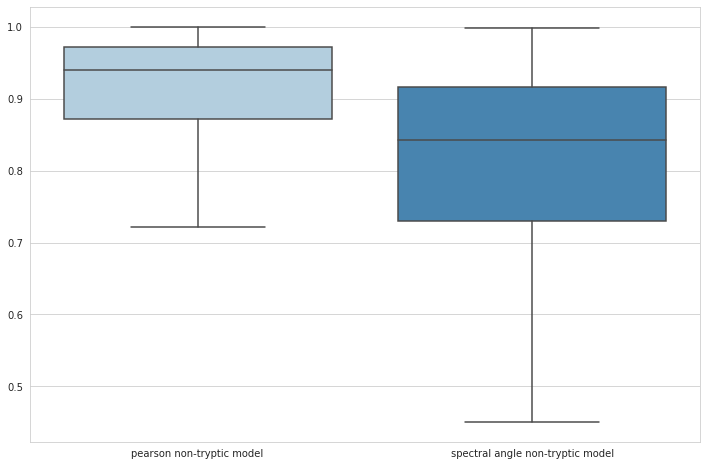

In [29]:
plt.figure(figsize=(12, 8))
model_perf = pd.DataFrame(columns=["pearson non-tryptic model", "spectral angle non-tryptic model"])
model_perf["pearson non-tryptic model"] = pear_corr
model_perf["spectral angle non-tryptic model"] = spec_corr
sns.set_style("whitegrid")
ax = sns.boxplot(data = model_perf, palette="Blues",showfliers = False)


plt.show()

# Performance on external tryptic and non-tryptic test set

In [30]:
tryptic_vectors, tryptic_targets, tryptic_psmids = load_data("data/tryptic_test_vector.pkl", "B")
non_tryptic_vectors, non_tryptic_targets, non_tryptic_psmids = load_data("data/non_tryptic_test_vector.pkl", "B")

In [31]:
tryptic_test = xgb.DMatrix(tryptic_vectors, label=tryptic_targets)
non_tryptic_test = xgb.DMatrix(non_tryptic_vectors, label=non_tryptic_targets)

In [32]:
predictions_tryptic = bst.predict(tryptic_test)
predictions_non_tryptic = bst.predict(non_tryptic_test)

In [33]:
ms2pip_pred_tryptic = pd.read_csv("data/HCD_PXD008034_Ecoli_HCD_pred_and_emp.csv")
ms2pip_pred_tryptic = ms2pip_pred_tryptic[ms2pip_pred_tryptic["ion"] == "B"]
ms2pip_pred_tryptic = ms2pip_pred_tryptic.drop([ 'charge','ion', 'ionnumber',"mz", "rt"], axis=1)

ms2pip_pred_non_tryptic = pd.read_csv("data/spec_lib_PXD005231_HCD_pred_and_emp.csv")
ms2pip_pred_non_tryptic = ms2pip_pred_non_tryptic[ms2pip_pred_non_tryptic["ion"] == "B"]
ms2pip_pred_non_tryptic = ms2pip_pred_non_tryptic.drop([ 'charge','ion', 'ionnumber',"mz"], axis=1)

In [34]:
tryptic_test_N = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
tryptic_new_model = Scorer(tryptic_psmids)
tryptic_test_N["pearson correlation"], tryptic_test_N["spectral angle"] = tryptic_new_model.psm_score(tryptic_targets,predictions_tryptic)
tryptic_test_N["type"] = "tryptic"

non_tryptic_test_N = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
non_tryptic_new_model = Scorer(non_tryptic_psmids)
non_tryptic_test_N["pearson correlation"], non_tryptic_test_N["spectral angle"] = non_tryptic_new_model.psm_score(non_tryptic_targets,predictions_non_tryptic)
non_tryptic_test_N["type"] = "non-tryptic"

New_model_perf = pd.concat([tryptic_test_N, non_tryptic_test_N])
New_model_perf["Model"] = "new model"

/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [35]:
tryptic_test_C = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
tryptic_current_model = Scorer(ms2pip_pred_tryptic["spec_id"])
tryptic_test_C["pearson correlation"], tryptic_test_C["spectral angle"] = tryptic_current_model.psm_score(ms2pip_pred_tryptic["target"],ms2pip_pred_tryptic["prediction"])
tryptic_test_C["type"] = "tryptic"

non_tryptic_test_C = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
non_tryptic_current_model = Scorer(ms2pip_pred_non_tryptic["spec_id"])
non_tryptic_test_C["pearson correlation"], non_tryptic_test_C["spectral angle"] = non_tryptic_current_model.psm_score(ms2pip_pred_non_tryptic["target"],ms2pip_pred_non_tryptic["prediction"])
non_tryptic_test_C["type"] = "non-tryptic"

Current_model_perf = pd.concat([tryptic_test_C, non_tryptic_test_C])
Current_model_perf["Model"] = "current model"

In [36]:
model_comparison = pd.concat([Current_model_perf, New_model_perf])

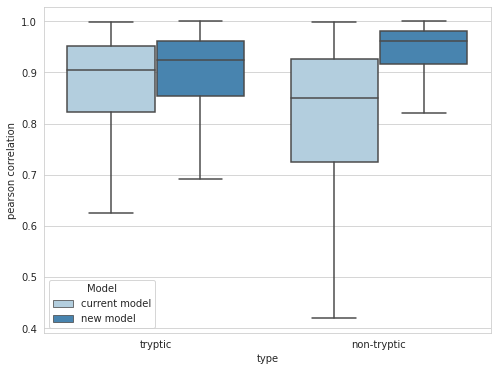

In [37]:
plt.figure(figsize=(8, 6))
sns.boxplot(data = model_comparison, x="type", y="pearson correlation",hue="Model", palette="Blues", showfliers = False)
plt.show()

## Median correlations

In [39]:
print(f'PC tryptic current model: {Current_model_perf["pearson correlation"][Current_model_perf.type=="tryptic"].median()}')
print(f'SA tryptic current model: {(Current_model_perf["spectral angle"][Current_model_perf.type == "tryptic"].median())}')
print(f'PC non-tryptic current model: {(Current_model_perf["pearson correlation"][Current_model_perf.type == "non-tryptic"].median())}')
print(f'SA non-tryptic current model: {(Current_model_perf["spectral angle"][Current_model_perf.type == "non-tryptic"].median())}\n')

print(f'PC tryptic new model: {(New_model_perf["pearson correlation"][New_model_perf.type == "tryptic"].median())}')
print(f'SA tryptic new model: {(New_model_perf["spectral angle"][New_model_perf.type == "tryptic"].median())}')
print(f'PC non-tryptic new model: {(New_model_perf["pearson correlation"][New_model_perf.type == "non-tryptic"].median())}')
print(f'SA non-tryptic new model: {(New_model_perf["spectral angle"][New_model_perf.type == "non-tryptic"].median())}')

PC tryptic current model: 0.9058151447299625
SA tryptic current model: 0.7766230748694172
PC non-tryptic current model: 0.8495001074955
SA non-tryptic current model: 0.7385337385873558

PC tryptic new model: 0.9237496376849679
SA tryptic new model: 0.8095234895645449
PC non-tryptic new model: 0.9607477408871725
SA non-tryptic new model: 0.8877740961299847


# Less in depth model

In [43]:
space= {
    'eta': hp.loguniform('eta', np.log(0.01), np.log(1)),
    'max_depth': hp.quniform('max_depth', 2, 7, 1),
    'max_leaves': hp.quniform('max_leaves', 5, 500, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'gamma' : hp.uniform ('gamma', 0.0,1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 500, 1),
    'subsample': hp.quniform('subsample', 0.5, 1 ,0.1),
    'reg_alpha': hp.quniform('reg_alpha', 0, 5 ,0.1),
    'grow_policy': hp.choice('grow_policy', ("lossguide", "depthwise"))
}

In [44]:
def objective(space):
    params = {
    "nthread": 64,
    "objective": "reg:squarederror",
    "eval_metric": 'rmse',
    "eta": space["eta"],
    "max_depth": int(space['max_depth']),
    "grow_policy":space['grow_policy'],
    "max_leaves":int(space["max_leaves"]),
    "min_child_weight": int(space["min_child_weight"]),
    "gamma": space['gamma'],
    "reg_lambda" : space['reg_lambda'],
    "colsample_bytree": space['colsample_bytree'],
    "subsample" : space["subsample"],
    "reg_alpha" : space["reg_alpha"]
    }
    print(params)
    tmp = xgb.cv(params, xtrain, nfold=4, num_boost_round=400, early_stopping_rounds=10, verbose_eval=True)
    rmse = tmp['test-rmse-mean'].min()

    print ("rmse:", rmse)
    return {'loss': rmse, 'status': STATUS_OK, "params": params}

In [45]:
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 30,
                        trials = trials)


best_hyperparams

{'nthread': 64, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.08334423535369392, 'max_depth': 5, 'grow_policy': 'depthwise', 'max_leaves': 33, 'min_child_weight': 286, 'gamma': 0.5137043977942877, 'reg_lambda': 0.521300193923012, 'colsample_bytree': 0.5726347582243592, 'subsample': 0.8, 'reg_alpha': 4.0}
[0]	train-rmse:8.61197+0.00033	test-rmse:8.61224+0.00115

[1]	train-rmse:7.91404+0.00044	test-rmse:7.91399+0.00147

[2]	train-rmse:7.27507+0.00030	test-rmse:7.27510+0.00156

[3]	train-rmse:6.69052+0.00041	test-rmse:6.69049+0.00133

[4]	train-rmse:6.15618+0.00029	test-rmse:6.15618+0.00155

[5]	train-rmse:5.66859+0.00040	test-rmse:5.66859+0.00157

[6]	train-rmse:5.22289+0.00044	test-rmse:5.22298+0.00142

[7]	train-rmse:4.81690+0.00079	test-rmse:4.81694+0.00161

[8]	train-rmse:4.44648+0.00052	test-rmse:4.44651+0.00161

[9]	train-rmse:4.10888+0.00073	test-rmse:4.10891+0.00160

[10]	train-rmse:3.80159+0.00130	test-rmse:3.80162+0.00199

[11]	train-rmse:3.52278+0.00163	test

[133]	train-rmse:1.02629+0.00086	test-rmse:1.02711+0.00127

[134]	train-rmse:1.02580+0.00080	test-rmse:1.02663+0.00123

[135]	train-rmse:1.02507+0.00075	test-rmse:1.02590+0.00113

[136]	train-rmse:1.02461+0.00072	test-rmse:1.02546+0.00107

[137]	train-rmse:1.02383+0.00073	test-rmse:1.02468+0.00109

[138]	train-rmse:1.02327+0.00069	test-rmse:1.02412+0.00110

[139]	train-rmse:1.02272+0.00063	test-rmse:1.02357+0.00100

[140]	train-rmse:1.02215+0.00056	test-rmse:1.02300+0.00098

[141]	train-rmse:1.02155+0.00057	test-rmse:1.02241+0.00103

[142]	train-rmse:1.02092+0.00058	test-rmse:1.02178+0.00111

[143]	train-rmse:1.02032+0.00044	test-rmse:1.02119+0.00098

[144]	train-rmse:1.01954+0.00050	test-rmse:1.02041+0.00103

[145]	train-rmse:1.01909+0.00060	test-rmse:1.01997+0.00112

[146]	train-rmse:1.01863+0.00055	test-rmse:1.01951+0.00107

[147]	train-rmse:1.01801+0.00050	test-rmse:1.01888+0.00105

[148]	train-rmse:1.01748+0.00051	test-rmse:1.01837+0.00108

[149]	train-rmse:1.01699+0.00049	test-rm

[0]	train-rmse:8.41963+0.00036	test-rmse:8.41995+0.00123                   

[1]	train-rmse:7.56845+0.00056	test-rmse:7.56775+0.00136                   

[2]	train-rmse:6.80920+0.00027	test-rmse:6.80883+0.00133                   

[3]	train-rmse:6.13369+0.00130	test-rmse:6.13366+0.00095                   

[4]	train-rmse:5.53331+0.00106	test-rmse:5.53323+0.00084                   

[5]	train-rmse:4.99972+0.00116	test-rmse:4.99977+0.00058                   

[6]	train-rmse:4.52649+0.00188	test-rmse:4.52647+0.00177                   

[7]	train-rmse:4.10805+0.00177	test-rmse:4.10798+0.00152                   

[8]	train-rmse:3.73725+0.00124	test-rmse:3.73724+0.00210                   

[9]	train-rmse:3.41222+0.00139	test-rmse:3.41220+0.00246                   

[10]	train-rmse:3.12731+0.00173	test-rmse:3.12732+0.00261                  

[11]	train-rmse:2.87768+0.00263	test-rmse:2.87769+0.00368                  

[12]	train-rmse:2.66004+0.00325	test-rmse:2.66001+0.00381                  


[212]	train-rmse:1.20034+0.00094	test-rmse:1.20044+0.00129                 

[213]	train-rmse:1.20002+0.00099	test-rmse:1.20011+0.00130                 

[214]	train-rmse:1.19970+0.00097	test-rmse:1.19979+0.00130                 

[215]	train-rmse:1.19936+0.00100	test-rmse:1.19945+0.00134                 

[216]	train-rmse:1.19904+0.00094	test-rmse:1.19913+0.00128                 

[217]	train-rmse:1.19869+0.00094	test-rmse:1.19878+0.00125                 

[218]	train-rmse:1.19837+0.00095	test-rmse:1.19847+0.00128                 

[219]	train-rmse:1.19808+0.00093	test-rmse:1.19817+0.00128                 

[220]	train-rmse:1.19773+0.00087	test-rmse:1.19783+0.00121                 

[221]	train-rmse:1.19750+0.00083	test-rmse:1.19760+0.00117                 

[222]	train-rmse:1.19725+0.00081	test-rmse:1.19734+0.00117                 

[223]	train-rmse:1.19691+0.00085	test-rmse:1.19700+0.00118                 

[224]	train-rmse:1.19658+0.00085	test-rmse:1.19667+0.00114                 


[18]	train-rmse:1.38674+0.00361	test-rmse:1.38684+0.00337                 

[19]	train-rmse:1.36350+0.00255	test-rmse:1.36361+0.00210                 

[20]	train-rmse:1.34663+0.00223	test-rmse:1.34671+0.00182                 

[21]	train-rmse:1.33122+0.00222	test-rmse:1.33130+0.00166                 

[22]	train-rmse:1.31954+0.00309	test-rmse:1.31960+0.00243                 

[23]	train-rmse:1.30805+0.00275	test-rmse:1.30813+0.00200                 

[24]	train-rmse:1.30005+0.00308	test-rmse:1.30011+0.00242                 

[25]	train-rmse:1.29248+0.00280	test-rmse:1.29255+0.00214                 

[26]	train-rmse:1.28562+0.00276	test-rmse:1.28570+0.00213                 

[27]	train-rmse:1.27757+0.00134	test-rmse:1.27768+0.00158                 

[28]	train-rmse:1.27278+0.00198	test-rmse:1.27291+0.00217                 

[29]	train-rmse:1.26717+0.00163	test-rmse:1.26728+0.00180                 

[30]	train-rmse:1.26233+0.00119	test-rmse:1.26242+0.00098                 

[31]	train-r

[232]	train-rmse:1.07365+0.00155	test-rmse:1.07403+0.00111                

[233]	train-rmse:1.07339+0.00154	test-rmse:1.07377+0.00109                

[234]	train-rmse:1.07311+0.00149	test-rmse:1.07350+0.00104                

[235]	train-rmse:1.07289+0.00161	test-rmse:1.07328+0.00114                

[236]	train-rmse:1.07266+0.00156	test-rmse:1.07305+0.00106                

[237]	train-rmse:1.07241+0.00157	test-rmse:1.07280+0.00108                

[238]	train-rmse:1.07219+0.00149	test-rmse:1.07257+0.00099                

[239]	train-rmse:1.07196+0.00144	test-rmse:1.07233+0.00095                

[240]	train-rmse:1.07161+0.00135	test-rmse:1.07199+0.00089                

[241]	train-rmse:1.07127+0.00136	test-rmse:1.07165+0.00085                

[242]	train-rmse:1.07098+0.00137	test-rmse:1.07137+0.00085                

[243]	train-rmse:1.07064+0.00128	test-rmse:1.07103+0.00072                

[244]	train-rmse:1.07036+0.00138	test-rmse:1.07075+0.00080                

[245]	train-

[39]	train-rmse:1.59088+0.00214	test-rmse:1.59103+0.00220                   

[40]	train-rmse:1.55810+0.00245	test-rmse:1.55824+0.00262                   

[41]	train-rmse:1.52781+0.00246	test-rmse:1.52798+0.00256                   

[42]	train-rmse:1.50013+0.00234	test-rmse:1.50029+0.00265                   

[43]	train-rmse:1.47455+0.00255	test-rmse:1.47471+0.00274                   

[44]	train-rmse:1.45133+0.00280	test-rmse:1.45151+0.00292                   

[45]	train-rmse:1.43018+0.00284	test-rmse:1.43036+0.00296                   

[46]	train-rmse:1.41078+0.00283	test-rmse:1.41095+0.00292                   

[47]	train-rmse:1.39288+0.00281	test-rmse:1.39306+0.00295                   

[48]	train-rmse:1.37659+0.00284	test-rmse:1.37677+0.00293                   

[49]	train-rmse:1.36161+0.00273	test-rmse:1.36180+0.00275                   

[50]	train-rmse:1.34809+0.00268	test-rmse:1.34828+0.00285                   

[51]	train-rmse:1.33590+0.00290	test-rmse:1.33610+0.00302       

[249]	train-rmse:1.07012+0.00078	test-rmse:1.07064+0.00037                  

[250]	train-rmse:1.06973+0.00073	test-rmse:1.07026+0.00032                  

[251]	train-rmse:1.06945+0.00067	test-rmse:1.06997+0.00028                  

[252]	train-rmse:1.06921+0.00064	test-rmse:1.06974+0.00031                  

[253]	train-rmse:1.06888+0.00075	test-rmse:1.06941+0.00035                  

[254]	train-rmse:1.06854+0.00074	test-rmse:1.06908+0.00037                  

[255]	train-rmse:1.06822+0.00072	test-rmse:1.06875+0.00038                  

[256]	train-rmse:1.06798+0.00069	test-rmse:1.06851+0.00030                  

[257]	train-rmse:1.06760+0.00070	test-rmse:1.06813+0.00037                  

[258]	train-rmse:1.06730+0.00072	test-rmse:1.06783+0.00037                  

[259]	train-rmse:1.06697+0.00069	test-rmse:1.06751+0.00039                  

[260]	train-rmse:1.06673+0.00070	test-rmse:1.06726+0.00042                  

[261]	train-rmse:1.06642+0.00070	test-rmse:1.06696+0.00042      

[52]	train-rmse:0.92212+0.00205	test-rmse:0.92557+0.00176                   

[53]	train-rmse:0.92087+0.00219	test-rmse:0.92437+0.00202                   

[54]	train-rmse:0.91976+0.00211	test-rmse:0.92332+0.00195                   

[55]	train-rmse:0.91894+0.00215	test-rmse:0.92257+0.00201                   

[56]	train-rmse:0.91838+0.00196	test-rmse:0.92207+0.00184                   

[57]	train-rmse:0.91721+0.00180	test-rmse:0.92094+0.00166                   

[58]	train-rmse:0.91631+0.00197	test-rmse:0.92011+0.00185                   

[59]	train-rmse:0.91553+0.00184	test-rmse:0.91940+0.00180                   

[60]	train-rmse:0.91459+0.00208	test-rmse:0.91853+0.00196                   

[61]	train-rmse:0.91378+0.00212	test-rmse:0.91779+0.00205                   

[62]	train-rmse:0.91251+0.00203	test-rmse:0.91660+0.00198                   

[63]	train-rmse:0.91156+0.00175	test-rmse:0.91570+0.00180                   

[64]	train-rmse:0.91069+0.00174	test-rmse:0.91490+0.00184       

[262]	train-rmse:0.84164+0.00085	test-rmse:0.85533+0.00081                  

[263]	train-rmse:0.84145+0.00083	test-rmse:0.85518+0.00086                  

[264]	train-rmse:0.84122+0.00078	test-rmse:0.85501+0.00081                  

[265]	train-rmse:0.84104+0.00082	test-rmse:0.85486+0.00082                  

[266]	train-rmse:0.84075+0.00078	test-rmse:0.85462+0.00085                  

[267]	train-rmse:0.84053+0.00081	test-rmse:0.85444+0.00093                  

[268]	train-rmse:0.84030+0.00082	test-rmse:0.85425+0.00080                  

[269]	train-rmse:0.84017+0.00083	test-rmse:0.85415+0.00085                  

[270]	train-rmse:0.84002+0.00081	test-rmse:0.85405+0.00080                  

[271]	train-rmse:0.83990+0.00082	test-rmse:0.85397+0.00080                  

[272]	train-rmse:0.83971+0.00090	test-rmse:0.85383+0.00083                  

[273]	train-rmse:0.83951+0.00093	test-rmse:0.85367+0.00080                  

[274]	train-rmse:0.83937+0.00090	test-rmse:0.85358+0.00082      

[63]	train-rmse:1.07764+0.00220	test-rmse:1.07810+0.00248                      

[64]	train-rmse:1.07609+0.00208	test-rmse:1.07656+0.00235                      

[65]	train-rmse:1.07456+0.00189	test-rmse:1.07503+0.00213                      

[66]	train-rmse:1.07288+0.00196	test-rmse:1.07336+0.00221                      

[67]	train-rmse:1.07114+0.00202	test-rmse:1.07162+0.00226                      

[68]	train-rmse:1.06969+0.00217	test-rmse:1.07017+0.00239                      

[69]	train-rmse:1.06822+0.00205	test-rmse:1.06869+0.00226                      

[70]	train-rmse:1.06682+0.00199	test-rmse:1.06730+0.00218                      

[71]	train-rmse:1.06529+0.00185	test-rmse:1.06578+0.00206                      

[72]	train-rmse:1.06406+0.00191	test-rmse:1.06456+0.00219                      

[73]	train-rmse:1.06286+0.00191	test-rmse:1.06335+0.00204                      

[74]	train-rmse:1.06163+0.00191	test-rmse:1.06213+0.00203                      

[75]	train-rmse:1.06028+0.00

[265]	train-rmse:0.96412+0.00103	test-rmse:0.96561+0.00149                     

[266]	train-rmse:0.96390+0.00109	test-rmse:0.96539+0.00154                     

[267]	train-rmse:0.96367+0.00112	test-rmse:0.96517+0.00156                     

[268]	train-rmse:0.96343+0.00112	test-rmse:0.96493+0.00158                     

[269]	train-rmse:0.96323+0.00112	test-rmse:0.96474+0.00157                     

[270]	train-rmse:0.96296+0.00117	test-rmse:0.96448+0.00162                     

[271]	train-rmse:0.96273+0.00109	test-rmse:0.96425+0.00153                     

[272]	train-rmse:0.96245+0.00109	test-rmse:0.96398+0.00152                     

[273]	train-rmse:0.96223+0.00110	test-rmse:0.96377+0.00157                     

[274]	train-rmse:0.96198+0.00113	test-rmse:0.96352+0.00161                     

[275]	train-rmse:0.96174+0.00114	test-rmse:0.96329+0.00163                     

[276]	train-rmse:0.96158+0.00114	test-rmse:0.96313+0.00163                     

[277]	train-rmse:0.96147+0.0

[61]	train-rmse:1.19257+0.00253	test-rmse:1.19276+0.00251                      

[62]	train-rmse:1.19106+0.00240	test-rmse:1.19125+0.00244                      

[63]	train-rmse:1.19020+0.00244	test-rmse:1.19040+0.00251                      

[64]	train-rmse:1.18916+0.00212	test-rmse:1.18935+0.00226                      

[65]	train-rmse:1.18795+0.00197	test-rmse:1.18816+0.00208                      

[66]	train-rmse:1.18702+0.00168	test-rmse:1.18724+0.00183                      

[67]	train-rmse:1.18593+0.00194	test-rmse:1.18613+0.00196                      

[68]	train-rmse:1.18468+0.00179	test-rmse:1.18489+0.00165                      

[69]	train-rmse:1.18333+0.00170	test-rmse:1.18355+0.00168                      

[70]	train-rmse:1.18229+0.00158	test-rmse:1.18249+0.00144                      

[71]	train-rmse:1.18136+0.00142	test-rmse:1.18155+0.00134                      

[72]	train-rmse:1.18042+0.00145	test-rmse:1.18063+0.00144                      

[73]	train-rmse:1.17915+0.00

[263]	train-rmse:1.09684+0.00103	test-rmse:1.09737+0.00130                     

[264]	train-rmse:1.09673+0.00104	test-rmse:1.09726+0.00130                     

[265]	train-rmse:1.09654+0.00102	test-rmse:1.09707+0.00128                     

[266]	train-rmse:1.09642+0.00102	test-rmse:1.09696+0.00125                     

[267]	train-rmse:1.09609+0.00096	test-rmse:1.09664+0.00115                     

[268]	train-rmse:1.09587+0.00095	test-rmse:1.09642+0.00108                     

[269]	train-rmse:1.09566+0.00090	test-rmse:1.09621+0.00103                     

[270]	train-rmse:1.09538+0.00095	test-rmse:1.09593+0.00104                     

[271]	train-rmse:1.09517+0.00091	test-rmse:1.09574+0.00100                     

[272]	train-rmse:1.09492+0.00085	test-rmse:1.09548+0.00094                     

[273]	train-rmse:1.09472+0.00081	test-rmse:1.09527+0.00092                     

[274]	train-rmse:1.09445+0.00079	test-rmse:1.09500+0.00079                     

[275]	train-rmse:1.09431+0.0

[58]	train-rmse:1.10606+0.00261	test-rmse:1.10634+0.00299                      

[59]	train-rmse:1.10436+0.00264	test-rmse:1.10465+0.00303                      

[60]	train-rmse:1.10295+0.00260	test-rmse:1.10323+0.00302                      

[61]	train-rmse:1.10144+0.00276	test-rmse:1.10171+0.00314                      

[62]	train-rmse:1.09967+0.00303	test-rmse:1.09995+0.00334                      

[63]	train-rmse:1.09857+0.00297	test-rmse:1.09886+0.00329                      

[64]	train-rmse:1.09655+0.00280	test-rmse:1.09685+0.00315                      

[65]	train-rmse:1.09475+0.00269	test-rmse:1.09504+0.00297                      

[66]	train-rmse:1.09349+0.00240	test-rmse:1.09379+0.00261                      

[67]	train-rmse:1.09199+0.00217	test-rmse:1.09229+0.00244                      

[68]	train-rmse:1.09081+0.00205	test-rmse:1.09112+0.00236                      

[69]	train-rmse:1.08982+0.00204	test-rmse:1.09014+0.00230                      

[70]	train-rmse:1.08830+0.00

[260]	train-rmse:0.99342+0.00174	test-rmse:0.99446+0.00182                     

[261]	train-rmse:0.99309+0.00168	test-rmse:0.99413+0.00178                     

[262]	train-rmse:0.99284+0.00171	test-rmse:0.99389+0.00179                     

[263]	train-rmse:0.99261+0.00178	test-rmse:0.99366+0.00185                     

[264]	train-rmse:0.99233+0.00186	test-rmse:0.99338+0.00191                     

[265]	train-rmse:0.99212+0.00189	test-rmse:0.99317+0.00194                     

[266]	train-rmse:0.99172+0.00198	test-rmse:0.99278+0.00201                     

[267]	train-rmse:0.99149+0.00203	test-rmse:0.99255+0.00203                     

[268]	train-rmse:0.99120+0.00209	test-rmse:0.99227+0.00209                     

[269]	train-rmse:0.99102+0.00208	test-rmse:0.99209+0.00207                     

[270]	train-rmse:0.99090+0.00206	test-rmse:0.99197+0.00204                     

[271]	train-rmse:0.99060+0.00191	test-rmse:0.99167+0.00192                     

[272]	train-rmse:0.99032+0.0

[55]	train-rmse:1.00202+0.00237	test-rmse:1.00452+0.00261                      

[56]	train-rmse:1.00084+0.00254	test-rmse:1.00341+0.00278                      

[57]	train-rmse:0.99988+0.00252	test-rmse:1.00247+0.00278                      

[58]	train-rmse:0.99801+0.00222	test-rmse:1.00064+0.00255                      

[59]	train-rmse:0.99709+0.00233	test-rmse:0.99975+0.00263                      

[60]	train-rmse:0.99594+0.00209	test-rmse:0.99864+0.00239                      

[61]	train-rmse:0.99472+0.00220	test-rmse:0.99743+0.00242                      

[62]	train-rmse:0.99327+0.00205	test-rmse:0.99602+0.00227                      

[63]	train-rmse:0.99191+0.00156	test-rmse:0.99470+0.00175                      

[64]	train-rmse:0.99113+0.00137	test-rmse:0.99395+0.00156                      

[65]	train-rmse:0.99024+0.00133	test-rmse:0.99309+0.00145                      

[66]	train-rmse:0.98935+0.00125	test-rmse:0.99224+0.00128                      

[67]	train-rmse:0.98843+0.00

[257]	train-rmse:0.91242+0.00082	test-rmse:0.92159+0.00168                     

[258]	train-rmse:0.91224+0.00081	test-rmse:0.92145+0.00169                     

[259]	train-rmse:0.91208+0.00073	test-rmse:0.92132+0.00161                     

[260]	train-rmse:0.91191+0.00072	test-rmse:0.92118+0.00161                     

[261]	train-rmse:0.91175+0.00072	test-rmse:0.92107+0.00160                     

[262]	train-rmse:0.91156+0.00068	test-rmse:0.92092+0.00158                     

[263]	train-rmse:0.91143+0.00072	test-rmse:0.92083+0.00163                     

[264]	train-rmse:0.91122+0.00066	test-rmse:0.92066+0.00157                     

[265]	train-rmse:0.91100+0.00065	test-rmse:0.92045+0.00155                     

[266]	train-rmse:0.91076+0.00062	test-rmse:0.92024+0.00150                     

[267]	train-rmse:0.91057+0.00063	test-rmse:0.92007+0.00151                     

[268]	train-rmse:0.91023+0.00050	test-rmse:0.91975+0.00133                     

[269]	train-rmse:0.91001+0.0

[53]	train-rmse:1.19256+0.00027	test-rmse:1.19280+0.00069                      

[54]	train-rmse:1.18533+0.00039	test-rmse:1.18558+0.00086                      

[55]	train-rmse:1.17827+0.00038	test-rmse:1.17854+0.00074                      

[56]	train-rmse:1.17257+0.00046	test-rmse:1.17286+0.00087                      

[57]	train-rmse:1.16710+0.00051	test-rmse:1.16739+0.00088                      

[58]	train-rmse:1.16220+0.00053	test-rmse:1.16250+0.00064                      

[59]	train-rmse:1.15744+0.00052	test-rmse:1.15773+0.00078                      

[60]	train-rmse:1.15282+0.00027	test-rmse:1.15313+0.00080                      

[61]	train-rmse:1.14894+0.00040	test-rmse:1.14925+0.00050                      

[62]	train-rmse:1.14509+0.00038	test-rmse:1.14541+0.00067                      

[63]	train-rmse:1.14138+0.00060	test-rmse:1.14170+0.00042                      

[64]	train-rmse:1.13821+0.00059	test-rmse:1.13854+0.00021                      

[65]	train-rmse:1.13523+0.00

[255]	train-rmse:0.99397+0.00085	test-rmse:0.99497+0.00050                     

[256]	train-rmse:0.99373+0.00090	test-rmse:0.99473+0.00057                     

[257]	train-rmse:0.99343+0.00096	test-rmse:0.99444+0.00067                     

[258]	train-rmse:0.99308+0.00095	test-rmse:0.99409+0.00063                     

[259]	train-rmse:0.99272+0.00095	test-rmse:0.99372+0.00067                     

[260]	train-rmse:0.99246+0.00099	test-rmse:0.99347+0.00072                     

[261]	train-rmse:0.99222+0.00099	test-rmse:0.99323+0.00075                     

[262]	train-rmse:0.99190+0.00098	test-rmse:0.99291+0.00073                     

[263]	train-rmse:0.99167+0.00099	test-rmse:0.99268+0.00077                     

[264]	train-rmse:0.99142+0.00096	test-rmse:0.99244+0.00076                     

[265]	train-rmse:0.99118+0.00094	test-rmse:0.99220+0.00078                     

[266]	train-rmse:0.99090+0.00093	test-rmse:0.99192+0.00079                     

[267]	train-rmse:0.99066+0.0

[50]	train-rmse:0.96308+0.00101	test-rmse:0.96506+0.00176                      

[51]	train-rmse:0.96195+0.00127	test-rmse:0.96396+0.00206                      

[52]	train-rmse:0.96047+0.00145	test-rmse:0.96247+0.00235                      

[53]	train-rmse:0.95906+0.00165	test-rmse:0.96108+0.00253                      

[54]	train-rmse:0.95808+0.00136	test-rmse:0.96011+0.00221                      

[55]	train-rmse:0.95725+0.00137	test-rmse:0.95932+0.00221                      

[56]	train-rmse:0.95628+0.00128	test-rmse:0.95840+0.00211                      

[57]	train-rmse:0.95544+0.00132	test-rmse:0.95760+0.00208                      

[58]	train-rmse:0.95403+0.00113	test-rmse:0.95621+0.00180                      

[59]	train-rmse:0.95306+0.00107	test-rmse:0.95529+0.00161                      

[60]	train-rmse:0.95193+0.00101	test-rmse:0.95421+0.00157                      

[61]	train-rmse:0.95099+0.00089	test-rmse:0.95330+0.00148                      

[62]	train-rmse:0.94967+0.00

[252]	train-rmse:0.87491+0.00174	test-rmse:0.88202+0.00278                     

[253]	train-rmse:0.87477+0.00171	test-rmse:0.88190+0.00274                     

[254]	train-rmse:0.87456+0.00166	test-rmse:0.88170+0.00269                     

[255]	train-rmse:0.87432+0.00156	test-rmse:0.88148+0.00258                     

[256]	train-rmse:0.87415+0.00157	test-rmse:0.88133+0.00259                     

[257]	train-rmse:0.87404+0.00157	test-rmse:0.88125+0.00259                     

[258]	train-rmse:0.87388+0.00147	test-rmse:0.88111+0.00250                     

[259]	train-rmse:0.87379+0.00147	test-rmse:0.88106+0.00250                     

[260]	train-rmse:0.87355+0.00151	test-rmse:0.88083+0.00254                     

[261]	train-rmse:0.87345+0.00148	test-rmse:0.88075+0.00251                     

[262]	train-rmse:0.87323+0.00136	test-rmse:0.88055+0.00239                     

[263]	train-rmse:0.87305+0.00144	test-rmse:0.88039+0.00247                     

[264]	train-rmse:0.87293+0.0

[48]	train-rmse:0.95595+0.00380	test-rmse:0.96060+0.00410                      

[49]	train-rmse:0.95491+0.00323	test-rmse:0.95965+0.00359                      

[50]	train-rmse:0.95366+0.00291	test-rmse:0.95849+0.00341                      

[51]	train-rmse:0.95253+0.00315	test-rmse:0.95742+0.00365                      

[52]	train-rmse:0.95141+0.00312	test-rmse:0.95640+0.00360                      

[53]	train-rmse:0.95021+0.00281	test-rmse:0.95528+0.00329                      

[54]	train-rmse:0.94890+0.00287	test-rmse:0.95405+0.00350                      

[55]	train-rmse:0.94795+0.00268	test-rmse:0.95315+0.00337                      

[56]	train-rmse:0.94702+0.00267	test-rmse:0.95229+0.00332                      

[57]	train-rmse:0.94590+0.00253	test-rmse:0.95125+0.00321                      

[58]	train-rmse:0.94488+0.00239	test-rmse:0.95033+0.00297                      

[59]	train-rmse:0.94391+0.00247	test-rmse:0.94946+0.00300                      

[60]	train-rmse:0.94302+0.00

[250]	train-rmse:0.86775+0.00194	test-rmse:0.88604+0.00231                     

[251]	train-rmse:0.86759+0.00190	test-rmse:0.88593+0.00227                     

[252]	train-rmse:0.86742+0.00187	test-rmse:0.88582+0.00225                     

[253]	train-rmse:0.86723+0.00186	test-rmse:0.88570+0.00227                     

[254]	train-rmse:0.86708+0.00186	test-rmse:0.88562+0.00226                     

[255]	train-rmse:0.86681+0.00171	test-rmse:0.88540+0.00210                     

[256]	train-rmse:0.86667+0.00168	test-rmse:0.88532+0.00205                     

[257]	train-rmse:0.86648+0.00166	test-rmse:0.88519+0.00204                     

[258]	train-rmse:0.86634+0.00167	test-rmse:0.88512+0.00202                     

[259]	train-rmse:0.86618+0.00165	test-rmse:0.88502+0.00202                     

[260]	train-rmse:0.86603+0.00166	test-rmse:0.88493+0.00204                     

[261]	train-rmse:0.86584+0.00160	test-rmse:0.88480+0.00196                     

[262]	train-rmse:0.86564+0.0

[45]	train-rmse:1.04774+0.00122	test-rmse:1.04871+0.00168                      

[46]	train-rmse:1.04655+0.00139	test-rmse:1.04750+0.00176                      

[47]	train-rmse:1.04493+0.00152	test-rmse:1.04593+0.00119                      

[48]	train-rmse:1.04380+0.00156	test-rmse:1.04483+0.00123                      

[49]	train-rmse:1.04259+0.00164	test-rmse:1.04365+0.00126                      

[50]	train-rmse:1.04166+0.00173	test-rmse:1.04271+0.00146                      

[51]	train-rmse:1.04044+0.00207	test-rmse:1.04151+0.00187                      

[52]	train-rmse:1.03961+0.00183	test-rmse:1.04068+0.00158                      

[53]	train-rmse:1.03818+0.00130	test-rmse:1.03924+0.00118                      

[54]	train-rmse:1.03721+0.00155	test-rmse:1.03829+0.00127                      

[55]	train-rmse:1.03634+0.00133	test-rmse:1.03745+0.00117                      

[56]	train-rmse:1.03535+0.00113	test-rmse:1.03650+0.00103                      

[57]	train-rmse:1.03444+0.00

[247]	train-rmse:0.94425+0.00194	test-rmse:0.94785+0.00316                     

[248]	train-rmse:0.94409+0.00186	test-rmse:0.94770+0.00307                     

[249]	train-rmse:0.94392+0.00186	test-rmse:0.94757+0.00307                     

[250]	train-rmse:0.94372+0.00180	test-rmse:0.94738+0.00299                     

[251]	train-rmse:0.94346+0.00187	test-rmse:0.94713+0.00307                     

[252]	train-rmse:0.94333+0.00190	test-rmse:0.94702+0.00310                     

[253]	train-rmse:0.94317+0.00189	test-rmse:0.94687+0.00309                     

[254]	train-rmse:0.94300+0.00193	test-rmse:0.94672+0.00313                     

[255]	train-rmse:0.94270+0.00201	test-rmse:0.94644+0.00321                     

[256]	train-rmse:0.94258+0.00202	test-rmse:0.94633+0.00322                     

[257]	train-rmse:0.94246+0.00201	test-rmse:0.94623+0.00321                     

[258]	train-rmse:0.94231+0.00199	test-rmse:0.94610+0.00318                     

[259]	train-rmse:0.94209+0.0

[42]	train-rmse:1.04245+0.00348	test-rmse:1.04306+0.00300                      

[43]	train-rmse:1.04002+0.00327	test-rmse:1.04063+0.00279                      

[44]	train-rmse:1.03818+0.00266	test-rmse:1.03879+0.00218                      

[45]	train-rmse:1.03664+0.00273	test-rmse:1.03726+0.00223                      

[46]	train-rmse:1.03451+0.00380	test-rmse:1.03512+0.00330                      

[47]	train-rmse:1.03238+0.00337	test-rmse:1.03303+0.00289                      

[48]	train-rmse:1.03085+0.00329	test-rmse:1.03150+0.00281                      

[49]	train-rmse:1.02920+0.00300	test-rmse:1.02987+0.00250                      

[50]	train-rmse:1.02758+0.00326	test-rmse:1.02829+0.00275                      

[51]	train-rmse:1.02602+0.00347	test-rmse:1.02673+0.00294                      

[52]	train-rmse:1.02433+0.00357	test-rmse:1.02508+0.00307                      

[53]	train-rmse:1.02316+0.00351	test-rmse:1.02394+0.00302                      

[54]	train-rmse:1.02183+0.00

[244]	train-rmse:0.92437+0.00162	test-rmse:0.92700+0.00122                     

[245]	train-rmse:0.92418+0.00163	test-rmse:0.92682+0.00119                     

[246]	train-rmse:0.92391+0.00160	test-rmse:0.92657+0.00118                     

[247]	train-rmse:0.92365+0.00168	test-rmse:0.92631+0.00126                     

[248]	train-rmse:0.92332+0.00171	test-rmse:0.92600+0.00127                     

[249]	train-rmse:0.92315+0.00178	test-rmse:0.92584+0.00133                     

[250]	train-rmse:0.92276+0.00192	test-rmse:0.92546+0.00141                     

[251]	train-rmse:0.92246+0.00204	test-rmse:0.92518+0.00148                     

[252]	train-rmse:0.92225+0.00194	test-rmse:0.92497+0.00138                     

[253]	train-rmse:0.92196+0.00189	test-rmse:0.92470+0.00135                     

[254]	train-rmse:0.92186+0.00188	test-rmse:0.92460+0.00134                     

[255]	train-rmse:0.92169+0.00192	test-rmse:0.92444+0.00135                     

[256]	train-rmse:0.92151+0.0

[40]	train-rmse:0.98463+0.00358	test-rmse:0.98784+0.00393                      

[41]	train-rmse:0.98335+0.00351	test-rmse:0.98664+0.00390                      

[42]	train-rmse:0.98200+0.00347	test-rmse:0.98530+0.00384                      

[43]	train-rmse:0.98054+0.00314	test-rmse:0.98392+0.00355                      

[44]	train-rmse:0.97890+0.00316	test-rmse:0.98233+0.00360                      

[45]	train-rmse:0.97750+0.00324	test-rmse:0.98105+0.00370                      

[46]	train-rmse:0.97599+0.00310	test-rmse:0.97960+0.00370                      

[47]	train-rmse:0.97454+0.00301	test-rmse:0.97823+0.00354                      

[48]	train-rmse:0.97341+0.00307	test-rmse:0.97714+0.00363                      

[49]	train-rmse:0.97207+0.00318	test-rmse:0.97593+0.00368                      

[50]	train-rmse:0.97082+0.00336	test-rmse:0.97471+0.00390                      

[51]	train-rmse:0.96980+0.00338	test-rmse:0.97374+0.00388                      

[52]	train-rmse:0.96888+0.00

[242]	train-rmse:0.88612+0.00216	test-rmse:0.90111+0.00275                     

[243]	train-rmse:0.88589+0.00215	test-rmse:0.90093+0.00276                     

[244]	train-rmse:0.88563+0.00204	test-rmse:0.90073+0.00264                     

[245]	train-rmse:0.88538+0.00197	test-rmse:0.90054+0.00257                     

[246]	train-rmse:0.88518+0.00192	test-rmse:0.90038+0.00251                     

[247]	train-rmse:0.88492+0.00186	test-rmse:0.90016+0.00245                     

[248]	train-rmse:0.88470+0.00174	test-rmse:0.90000+0.00232                     

[249]	train-rmse:0.88452+0.00175	test-rmse:0.89988+0.00232                     

[250]	train-rmse:0.88431+0.00179	test-rmse:0.89972+0.00233                     

[251]	train-rmse:0.88409+0.00179	test-rmse:0.89953+0.00234                     

[252]	train-rmse:0.88390+0.00181	test-rmse:0.89939+0.00236                     

[253]	train-rmse:0.88361+0.00171	test-rmse:0.89914+0.00228                     

[254]	train-rmse:0.88332+0.0

[38]	train-rmse:1.01366+0.00279	test-rmse:1.01456+0.00300                      

[39]	train-rmse:1.01143+0.00263	test-rmse:1.01234+0.00288                      

[40]	train-rmse:1.00905+0.00260	test-rmse:1.01001+0.00282                      

[41]	train-rmse:1.00723+0.00241	test-rmse:1.00820+0.00264                      

[42]	train-rmse:1.00541+0.00215	test-rmse:1.00640+0.00239                      

[43]	train-rmse:1.00351+0.00192	test-rmse:1.00453+0.00221                      

[44]	train-rmse:1.00183+0.00176	test-rmse:1.00286+0.00202                      

[45]	train-rmse:0.99968+0.00110	test-rmse:1.00072+0.00157                      

[46]	train-rmse:0.99785+0.00116	test-rmse:0.99891+0.00161                      

[47]	train-rmse:0.99559+0.00112	test-rmse:0.99668+0.00154                      

[48]	train-rmse:0.99382+0.00110	test-rmse:0.99494+0.00161                      

[49]	train-rmse:0.99183+0.00125	test-rmse:0.99296+0.00177                      

[50]	train-rmse:0.99022+0.00

[240]	train-rmse:0.89305+0.00105	test-rmse:0.89746+0.00126                     

[241]	train-rmse:0.89278+0.00116	test-rmse:0.89722+0.00138                     

[242]	train-rmse:0.89257+0.00108	test-rmse:0.89702+0.00129                     

[243]	train-rmse:0.89240+0.00106	test-rmse:0.89687+0.00126                     

[244]	train-rmse:0.89212+0.00099	test-rmse:0.89661+0.00119                     

[245]	train-rmse:0.89197+0.00096	test-rmse:0.89647+0.00115                     

[246]	train-rmse:0.89175+0.00108	test-rmse:0.89626+0.00130                     

[247]	train-rmse:0.89159+0.00106	test-rmse:0.89611+0.00129                     

[248]	train-rmse:0.89135+0.00104	test-rmse:0.89588+0.00127                     

[249]	train-rmse:0.89117+0.00108	test-rmse:0.89572+0.00130                     

[250]	train-rmse:0.89096+0.00110	test-rmse:0.89552+0.00132                     

[251]	train-rmse:0.89080+0.00100	test-rmse:0.89537+0.00125                     

[252]	train-rmse:0.89056+0.0

[36]	train-rmse:1.32850+0.00206	test-rmse:1.32863+0.00215                      

[37]	train-rmse:1.32551+0.00266	test-rmse:1.32563+0.00265                      

[38]	train-rmse:1.32284+0.00259	test-rmse:1.32296+0.00253                      

[39]	train-rmse:1.32006+0.00245	test-rmse:1.32017+0.00244                      

[40]	train-rmse:1.31732+0.00246	test-rmse:1.31743+0.00245                      

[41]	train-rmse:1.31445+0.00276	test-rmse:1.31456+0.00275                      

[42]	train-rmse:1.31092+0.00248	test-rmse:1.31104+0.00269                      

[43]	train-rmse:1.30769+0.00158	test-rmse:1.30778+0.00119                      

[44]	train-rmse:1.30524+0.00153	test-rmse:1.30532+0.00105                      

[45]	train-rmse:1.30288+0.00128	test-rmse:1.30297+0.00092                      

[46]	train-rmse:1.30022+0.00111	test-rmse:1.30032+0.00118                      

[47]	train-rmse:1.29752+0.00103	test-rmse:1.29763+0.00144                      

[48]	train-rmse:1.29539+0.00

[238]	train-rmse:1.16402+0.00049	test-rmse:1.16421+0.00055                     

[239]	train-rmse:1.16383+0.00048	test-rmse:1.16402+0.00054                     

[240]	train-rmse:1.16361+0.00049	test-rmse:1.16380+0.00047                     

[241]	train-rmse:1.16334+0.00042	test-rmse:1.16352+0.00040                     

[242]	train-rmse:1.16315+0.00045	test-rmse:1.16334+0.00038                     

[243]	train-rmse:1.16288+0.00055	test-rmse:1.16306+0.00036                     

[244]	train-rmse:1.16255+0.00057	test-rmse:1.16273+0.00034                     

[245]	train-rmse:1.16223+0.00058	test-rmse:1.16241+0.00039                     

[246]	train-rmse:1.16194+0.00053	test-rmse:1.16212+0.00036                     

[247]	train-rmse:1.16159+0.00053	test-rmse:1.16178+0.00045                     

[248]	train-rmse:1.16136+0.00050	test-rmse:1.16156+0.00038                     

[249]	train-rmse:1.16103+0.00062	test-rmse:1.16122+0.00052                     

[250]	train-rmse:1.16067+0.0

[33]	train-rmse:1.20460+0.00345	test-rmse:1.20487+0.00324                      

[34]	train-rmse:1.19265+0.00276	test-rmse:1.19295+0.00245                      

[35]	train-rmse:1.18289+0.00254	test-rmse:1.18319+0.00227                      

[36]	train-rmse:1.17395+0.00275	test-rmse:1.17425+0.00247                      

[37]	train-rmse:1.16594+0.00293	test-rmse:1.16625+0.00255                      

[38]	train-rmse:1.15925+0.00266	test-rmse:1.15957+0.00233                      

[39]	train-rmse:1.15312+0.00306	test-rmse:1.15346+0.00269                      

[40]	train-rmse:1.14776+0.00324	test-rmse:1.14811+0.00284                      

[41]	train-rmse:1.14234+0.00309	test-rmse:1.14269+0.00270                      

[42]	train-rmse:1.13766+0.00245	test-rmse:1.13800+0.00200                      

[43]	train-rmse:1.13351+0.00224	test-rmse:1.13388+0.00185                      

[44]	train-rmse:1.13002+0.00229	test-rmse:1.13039+0.00193                      

[45]	train-rmse:1.12642+0.00

[235]	train-rmse:0.97510+0.00091	test-rmse:0.97628+0.00134                     

[236]	train-rmse:0.97491+0.00096	test-rmse:0.97609+0.00140                     

[237]	train-rmse:0.97464+0.00109	test-rmse:0.97583+0.00150                     

[238]	train-rmse:0.97437+0.00110	test-rmse:0.97556+0.00152                     

[239]	train-rmse:0.97407+0.00104	test-rmse:0.97527+0.00147                     

[240]	train-rmse:0.97384+0.00103	test-rmse:0.97505+0.00144                     

[241]	train-rmse:0.97357+0.00092	test-rmse:0.97478+0.00137                     

[242]	train-rmse:0.97330+0.00083	test-rmse:0.97452+0.00122                     

[243]	train-rmse:0.97303+0.00078	test-rmse:0.97426+0.00120                     

[244]	train-rmse:0.97277+0.00083	test-rmse:0.97400+0.00122                     

[245]	train-rmse:0.97251+0.00095	test-rmse:0.97374+0.00133                     

[246]	train-rmse:0.97233+0.00103	test-rmse:0.97356+0.00142                     

[247]	train-rmse:0.97213+0.0

[30]	train-rmse:1.00041+0.00316	test-rmse:1.00332+0.00306                      

[31]	train-rmse:0.99868+0.00312	test-rmse:1.00166+0.00303                      

[32]	train-rmse:0.99682+0.00323	test-rmse:0.99988+0.00300                      

[33]	train-rmse:0.99495+0.00343	test-rmse:0.99805+0.00319                      

[34]	train-rmse:0.99278+0.00330	test-rmse:0.99601+0.00304                      

[35]	train-rmse:0.99079+0.00261	test-rmse:0.99405+0.00250                      

[36]	train-rmse:0.98893+0.00273	test-rmse:0.99225+0.00256                      

[37]	train-rmse:0.98709+0.00294	test-rmse:0.99050+0.00258                      

[38]	train-rmse:0.98531+0.00310	test-rmse:0.98875+0.00255                      

[39]	train-rmse:0.98417+0.00337	test-rmse:0.98774+0.00279                      

[40]	train-rmse:0.98283+0.00341	test-rmse:0.98655+0.00285                      

[41]	train-rmse:0.98189+0.00339	test-rmse:0.98570+0.00282                      

[42]	train-rmse:0.98059+0.00

[232]	train-rmse:0.88982+0.00133	test-rmse:0.90618+0.00205                     

[233]	train-rmse:0.88967+0.00135	test-rmse:0.90610+0.00204                     

[234]	train-rmse:0.88950+0.00133	test-rmse:0.90599+0.00199                     

[235]	train-rmse:0.88935+0.00134	test-rmse:0.90589+0.00200                     

[236]	train-rmse:0.88917+0.00133	test-rmse:0.90578+0.00198                     

[237]	train-rmse:0.88893+0.00135	test-rmse:0.90559+0.00199                     

[238]	train-rmse:0.88874+0.00139	test-rmse:0.90547+0.00204                     

[239]	train-rmse:0.88860+0.00143	test-rmse:0.90538+0.00206                     

[240]	train-rmse:0.88839+0.00146	test-rmse:0.90522+0.00215                     

[241]	train-rmse:0.88828+0.00147	test-rmse:0.90517+0.00218                     

[242]	train-rmse:0.88814+0.00144	test-rmse:0.90509+0.00216                     

[243]	train-rmse:0.88795+0.00142	test-rmse:0.90499+0.00216                     

[244]	train-rmse:0.88776+0.0

[27]	train-rmse:1.22617+0.00135	test-rmse:1.22634+0.00166                      

[28]	train-rmse:1.21734+0.00163	test-rmse:1.21749+0.00205                      

[29]	train-rmse:1.21111+0.00185	test-rmse:1.21128+0.00224                      

[30]	train-rmse:1.20523+0.00232	test-rmse:1.20540+0.00274                      

[31]	train-rmse:1.19929+0.00217	test-rmse:1.19944+0.00265                      

[32]	train-rmse:1.19440+0.00243	test-rmse:1.19455+0.00277                      

[33]	train-rmse:1.18863+0.00157	test-rmse:1.18880+0.00194                      

[34]	train-rmse:1.18434+0.00216	test-rmse:1.18451+0.00239                      

[35]	train-rmse:1.18074+0.00211	test-rmse:1.18091+0.00241                      

[36]	train-rmse:1.17653+0.00262	test-rmse:1.17669+0.00296                      

[37]	train-rmse:1.17349+0.00249	test-rmse:1.17364+0.00281                      

[38]	train-rmse:1.17022+0.00193	test-rmse:1.17038+0.00228                      

[39]	train-rmse:1.16739+0.00

[229]	train-rmse:1.01649+0.00137	test-rmse:1.01739+0.00132                     

[230]	train-rmse:1.01618+0.00145	test-rmse:1.01709+0.00141                     

[231]	train-rmse:1.01595+0.00144	test-rmse:1.01686+0.00143                     

[232]	train-rmse:1.01572+0.00137	test-rmse:1.01662+0.00140                     

[233]	train-rmse:1.01537+0.00134	test-rmse:1.01628+0.00143                     

[234]	train-rmse:1.01522+0.00132	test-rmse:1.01613+0.00141                     

[235]	train-rmse:1.01486+0.00151	test-rmse:1.01578+0.00159                     

[236]	train-rmse:1.01447+0.00171	test-rmse:1.01538+0.00175                     

[237]	train-rmse:1.01419+0.00177	test-rmse:1.01510+0.00177                     

[238]	train-rmse:1.01391+0.00178	test-rmse:1.01482+0.00173                     

[239]	train-rmse:1.01355+0.00194	test-rmse:1.01446+0.00186                     

[240]	train-rmse:1.01324+0.00187	test-rmse:1.01415+0.00183                     

[241]	train-rmse:1.01301+0.0

[24]	train-rmse:4.68447+0.00055	test-rmse:4.68450+0.00110                      

[25]	train-rmse:4.56005+0.00047	test-rmse:4.56006+0.00114                      

[26]	train-rmse:4.43927+0.00044	test-rmse:4.43929+0.00106                      

[27]	train-rmse:4.32207+0.00043	test-rmse:4.32213+0.00103                      

[28]	train-rmse:4.20851+0.00046	test-rmse:4.20855+0.00093                      

[29]	train-rmse:4.09835+0.00051	test-rmse:4.09840+0.00089                      

[30]	train-rmse:3.99158+0.00052	test-rmse:3.99161+0.00087                      

[31]	train-rmse:3.88801+0.00049	test-rmse:3.88807+0.00096                      

[32]	train-rmse:3.78766+0.00047	test-rmse:3.78771+0.00100                      

[33]	train-rmse:3.69039+0.00044	test-rmse:3.69044+0.00100                      

[34]	train-rmse:3.59603+0.00037	test-rmse:3.59610+0.00102                      

[35]	train-rmse:3.50461+0.00034	test-rmse:3.50469+0.00100                      

[36]	train-rmse:3.41609+0.00

[226]	train-rmse:0.97065+0.00056	test-rmse:0.97241+0.00050                     

[227]	train-rmse:0.97028+0.00057	test-rmse:0.97204+0.00049                     

[228]	train-rmse:0.96985+0.00062	test-rmse:0.97162+0.00047                     

[229]	train-rmse:0.96944+0.00058	test-rmse:0.97122+0.00045                     

[230]	train-rmse:0.96900+0.00062	test-rmse:0.97078+0.00044                     

[231]	train-rmse:0.96842+0.00062	test-rmse:0.97021+0.00039                     

[232]	train-rmse:0.96795+0.00063	test-rmse:0.96974+0.00035                     

[233]	train-rmse:0.96755+0.00060	test-rmse:0.96936+0.00039                     

[234]	train-rmse:0.96720+0.00064	test-rmse:0.96900+0.00041                     

[235]	train-rmse:0.96682+0.00069	test-rmse:0.96864+0.00042                     

[236]	train-rmse:0.96641+0.00063	test-rmse:0.96823+0.00046                     

[237]	train-rmse:0.96606+0.00060	test-rmse:0.96788+0.00045                     

[238]	train-rmse:0.96563+0.0

[22]	train-rmse:0.97701+0.00173	test-rmse:0.97922+0.00105                      

[23]	train-rmse:0.97396+0.00209	test-rmse:0.97632+0.00126                      

[24]	train-rmse:0.97095+0.00233	test-rmse:0.97337+0.00149                      

[25]	train-rmse:0.96854+0.00259	test-rmse:0.97106+0.00181                      

[26]	train-rmse:0.96565+0.00245	test-rmse:0.96825+0.00159                      

[27]	train-rmse:0.96255+0.00237	test-rmse:0.96521+0.00159                      

[28]	train-rmse:0.95975+0.00273	test-rmse:0.96247+0.00201                      

[29]	train-rmse:0.95748+0.00247	test-rmse:0.96026+0.00182                      

[30]	train-rmse:0.95454+0.00209	test-rmse:0.95741+0.00137                      

[31]	train-rmse:0.95217+0.00210	test-rmse:0.95513+0.00161                      

[32]	train-rmse:0.94974+0.00142	test-rmse:0.95277+0.00056                      

[33]	train-rmse:0.94700+0.00202	test-rmse:0.95012+0.00115                      

[34]	train-rmse:0.94475+0.00

[221]	train-rmse:0.84419+0.00135	test-rmse:0.85981+0.00137                      

[222]	train-rmse:0.84394+0.00142	test-rmse:0.85963+0.00140                      

[223]	train-rmse:0.84371+0.00138	test-rmse:0.85947+0.00139                      

[224]	train-rmse:0.84352+0.00141	test-rmse:0.85934+0.00138                      

[225]	train-rmse:0.84331+0.00137	test-rmse:0.85920+0.00135                      

[226]	train-rmse:0.84312+0.00138	test-rmse:0.85909+0.00135                      

[227]	train-rmse:0.84291+0.00138	test-rmse:0.85893+0.00133                      

[228]	train-rmse:0.84277+0.00139	test-rmse:0.85886+0.00133                      

[229]	train-rmse:0.84260+0.00142	test-rmse:0.85876+0.00136                      

[230]	train-rmse:0.84242+0.00142	test-rmse:0.85864+0.00134                      

[231]	train-rmse:0.84216+0.00138	test-rmse:0.85843+0.00130                      

[232]	train-rmse:0.84193+0.00139	test-rmse:0.85826+0.00127                      

[233]	train-rmse

[12]	train-rmse:1.01426+0.00286	test-rmse:1.01592+0.00302                               

[13]	train-rmse:1.00772+0.00338	test-rmse:1.00954+0.00338                               

[14]	train-rmse:1.00097+0.00340	test-rmse:1.00284+0.00376                               

[15]	train-rmse:0.99616+0.00298	test-rmse:0.99809+0.00348                               

[16]	train-rmse:0.99129+0.00366	test-rmse:0.99331+0.00367                               

[17]	train-rmse:0.98648+0.00440	test-rmse:0.98857+0.00449                               

[18]	train-rmse:0.98138+0.00353	test-rmse:0.98359+0.00365                               

[19]	train-rmse:0.97758+0.00418	test-rmse:0.97988+0.00437                               

[20]	train-rmse:0.97399+0.00428	test-rmse:0.97638+0.00430                               

[21]	train-rmse:0.97054+0.00347	test-rmse:0.97302+0.00350                               

[22]	train-rmse:0.96635+0.00261	test-rmse:0.96890+0.00256                               

[23]	train

[194]	train-rmse:0.85023+0.00083	test-rmse:0.86718+0.00132                              

[195]	train-rmse:0.85002+0.00083	test-rmse:0.86702+0.00135                              

[196]	train-rmse:0.84972+0.00072	test-rmse:0.86681+0.00129                              

[197]	train-rmse:0.84955+0.00071	test-rmse:0.86674+0.00126                              

[198]	train-rmse:0.84931+0.00071	test-rmse:0.86660+0.00127                              

[199]	train-rmse:0.84909+0.00072	test-rmse:0.86644+0.00125                              

[200]	train-rmse:0.84884+0.00067	test-rmse:0.86627+0.00122                              

[201]	train-rmse:0.84854+0.00068	test-rmse:0.86605+0.00128                              

[202]	train-rmse:0.84833+0.00070	test-rmse:0.86592+0.00130                              

[203]	train-rmse:0.84809+0.00071	test-rmse:0.86580+0.00130                              

[204]	train-rmse:0.84785+0.00066	test-rmse:0.86564+0.00129                              

[205]	trai

[376]	train-rmse:0.81850+0.00049	test-rmse:0.84933+0.00102                              

[377]	train-rmse:0.81838+0.00049	test-rmse:0.84930+0.00104                              

[378]	train-rmse:0.81827+0.00050	test-rmse:0.84926+0.00103                              

[379]	train-rmse:0.81813+0.00048	test-rmse:0.84919+0.00102                              

[380]	train-rmse:0.81805+0.00048	test-rmse:0.84917+0.00102                              

[381]	train-rmse:0.81794+0.00047	test-rmse:0.84912+0.00100                              

[382]	train-rmse:0.81782+0.00050	test-rmse:0.84907+0.00103                              

[383]	train-rmse:0.81771+0.00048	test-rmse:0.84903+0.00102                              

[384]	train-rmse:0.81757+0.00051	test-rmse:0.84897+0.00105                              

[385]	train-rmse:0.81744+0.00052	test-rmse:0.84891+0.00106                              

[386]	train-rmse:0.81734+0.00052	test-rmse:0.84889+0.00107                              

[387]	trai

[152]	train-rmse:0.86362+0.00098	test-rmse:0.87317+0.00108                              

[153]	train-rmse:0.86332+0.00090	test-rmse:0.87293+0.00101                              

[154]	train-rmse:0.86304+0.00092	test-rmse:0.87271+0.00102                              

[155]	train-rmse:0.86279+0.00088	test-rmse:0.87250+0.00103                              

[156]	train-rmse:0.86261+0.00091	test-rmse:0.87237+0.00108                              

[157]	train-rmse:0.86220+0.00090	test-rmse:0.87203+0.00100                              

[158]	train-rmse:0.86191+0.00096	test-rmse:0.87180+0.00114                              

[159]	train-rmse:0.86164+0.00092	test-rmse:0.87158+0.00106                              

[160]	train-rmse:0.86129+0.00084	test-rmse:0.87129+0.00106                              

[161]	train-rmse:0.86092+0.00073	test-rmse:0.87098+0.00101                              

[162]	train-rmse:0.86053+0.00071	test-rmse:0.87064+0.00103                              

[163]	trai

[334]	train-rmse:0.82521+0.00059	test-rmse:0.84484+0.00105                              

[335]	train-rmse:0.82509+0.00059	test-rmse:0.84478+0.00104                              

[336]	train-rmse:0.82495+0.00060	test-rmse:0.84471+0.00104                              

[337]	train-rmse:0.82480+0.00063	test-rmse:0.84461+0.00110                              

[338]	train-rmse:0.82453+0.00063	test-rmse:0.84439+0.00118                              

[339]	train-rmse:0.82432+0.00068	test-rmse:0.84421+0.00118                              

[340]	train-rmse:0.82422+0.00067	test-rmse:0.84416+0.00118                              

[341]	train-rmse:0.82408+0.00069	test-rmse:0.84408+0.00121                              

[342]	train-rmse:0.82397+0.00068	test-rmse:0.84402+0.00121                              

[343]	train-rmse:0.82377+0.00060	test-rmse:0.84387+0.00116                              

[344]	train-rmse:0.82368+0.00061	test-rmse:0.84383+0.00117                              

[345]	trai

[122]	train-rmse:0.87557+0.00217	test-rmse:0.89049+0.00235                     

[123]	train-rmse:0.87515+0.00213	test-rmse:0.89018+0.00228                     

[124]	train-rmse:0.87473+0.00213	test-rmse:0.88988+0.00225                     

[125]	train-rmse:0.87428+0.00191	test-rmse:0.88955+0.00205                     

[126]	train-rmse:0.87394+0.00199	test-rmse:0.88931+0.00210                     

[127]	train-rmse:0.87342+0.00196	test-rmse:0.88892+0.00210                     

[128]	train-rmse:0.87313+0.00198	test-rmse:0.88872+0.00206                     

[129]	train-rmse:0.87281+0.00183	test-rmse:0.88850+0.00193                     

[130]	train-rmse:0.87237+0.00174	test-rmse:0.88818+0.00188                     

[131]	train-rmse:0.87198+0.00176	test-rmse:0.88790+0.00187                     

[132]	train-rmse:0.87161+0.00171	test-rmse:0.88765+0.00184                     

[133]	train-rmse:0.87123+0.00160	test-rmse:0.88737+0.00175                     

[134]	train-rmse:0.87082+0.0

[324]	train-rmse:0.82864+0.00089	test-rmse:0.86437+0.00145                     

[325]	train-rmse:0.82848+0.00087	test-rmse:0.86428+0.00145                     

[326]	train-rmse:0.82834+0.00087	test-rmse:0.86425+0.00145                     

[327]	train-rmse:0.82819+0.00083	test-rmse:0.86422+0.00142                     

[328]	train-rmse:0.82803+0.00081	test-rmse:0.86414+0.00142                     

[329]	train-rmse:0.82787+0.00084	test-rmse:0.86408+0.00142                     

[330]	train-rmse:0.82770+0.00084	test-rmse:0.86401+0.00144                     

[331]	train-rmse:0.82759+0.00084	test-rmse:0.86398+0.00144                     

[332]	train-rmse:0.82740+0.00085	test-rmse:0.86390+0.00142                     

[333]	train-rmse:0.82722+0.00082	test-rmse:0.86384+0.00142                     

[334]	train-rmse:0.82706+0.00085	test-rmse:0.86378+0.00143                     

[335]	train-rmse:0.82691+0.00087	test-rmse:0.86374+0.00144                     

[336]	train-rmse:0.82678+0.0

[119]	train-rmse:2.71709+0.00018	test-rmse:2.71727+0.00105                     

[120]	train-rmse:2.69232+0.00017	test-rmse:2.69249+0.00105                     

[121]	train-rmse:2.66784+0.00019	test-rmse:2.66801+0.00104                     

[122]	train-rmse:2.64371+0.00019	test-rmse:2.64389+0.00106                     

[123]	train-rmse:2.61985+0.00021	test-rmse:2.62003+0.00111                     

[124]	train-rmse:2.59631+0.00027	test-rmse:2.59649+0.00111                     

[125]	train-rmse:2.57308+0.00027	test-rmse:2.57327+0.00112                     

[126]	train-rmse:2.55016+0.00026	test-rmse:2.55035+0.00113                     

[127]	train-rmse:2.52751+0.00027	test-rmse:2.52770+0.00120                     

[128]	train-rmse:2.50517+0.00024	test-rmse:2.50537+0.00116                     

[129]	train-rmse:2.48306+0.00023	test-rmse:2.48327+0.00116                     

[130]	train-rmse:2.46124+0.00026	test-rmse:2.46145+0.00115                     

[131]	train-rmse:2.43977+0.0

[321]	train-rmse:1.06954+0.00049	test-rmse:1.07050+0.00044                     

[322]	train-rmse:1.06847+0.00051	test-rmse:1.06943+0.00041                     

[323]	train-rmse:1.06742+0.00051	test-rmse:1.06839+0.00046                     

[324]	train-rmse:1.06638+0.00053	test-rmse:1.06735+0.00043                     

[325]	train-rmse:1.06533+0.00050	test-rmse:1.06630+0.00041                     

[326]	train-rmse:1.06431+0.00050	test-rmse:1.06529+0.00045                     

[327]	train-rmse:1.06333+0.00047	test-rmse:1.06430+0.00051                     

[328]	train-rmse:1.06238+0.00044	test-rmse:1.06336+0.00050                     

[329]	train-rmse:1.06145+0.00041	test-rmse:1.06243+0.00051                     

[330]	train-rmse:1.06050+0.00043	test-rmse:1.06148+0.00050                     

[331]	train-rmse:1.05953+0.00042	test-rmse:1.06052+0.00051                     

[332]	train-rmse:1.05863+0.00043	test-rmse:1.05962+0.00051                     

[333]	train-rmse:1.05771+0.0

[116]	train-rmse:0.87991+0.00142	test-rmse:0.88761+0.00199                     

[117]	train-rmse:0.87961+0.00153	test-rmse:0.88737+0.00209                     

[118]	train-rmse:0.87908+0.00134	test-rmse:0.88689+0.00191                     

[119]	train-rmse:0.87871+0.00137	test-rmse:0.88660+0.00194                     

[120]	train-rmse:0.87830+0.00130	test-rmse:0.88623+0.00188                     

[121]	train-rmse:0.87789+0.00136	test-rmse:0.88587+0.00194                     

[122]	train-rmse:0.87739+0.00139	test-rmse:0.88543+0.00199                     

[123]	train-rmse:0.87676+0.00139	test-rmse:0.88487+0.00200                     

[124]	train-rmse:0.87646+0.00145	test-rmse:0.88463+0.00206                     

[125]	train-rmse:0.87600+0.00147	test-rmse:0.88422+0.00208                     

[126]	train-rmse:0.87557+0.00161	test-rmse:0.88384+0.00224                     

[127]	train-rmse:0.87522+0.00170	test-rmse:0.88354+0.00230                     

[128]	train-rmse:0.87480+0.0

[318]	train-rmse:0.82830+0.00124	test-rmse:0.84730+0.00183                     

[319]	train-rmse:0.82818+0.00122	test-rmse:0.84724+0.00183                     

[320]	train-rmse:0.82804+0.00121	test-rmse:0.84715+0.00182                     

[321]	train-rmse:0.82784+0.00121	test-rmse:0.84702+0.00181                     

[322]	train-rmse:0.82768+0.00121	test-rmse:0.84690+0.00183                     

[323]	train-rmse:0.82756+0.00123	test-rmse:0.84685+0.00184                     

[324]	train-rmse:0.82739+0.00129	test-rmse:0.84672+0.00190                     

[325]	train-rmse:0.82720+0.00129	test-rmse:0.84660+0.00191                     

[326]	train-rmse:0.82704+0.00128	test-rmse:0.84648+0.00191                     

[327]	train-rmse:0.82686+0.00127	test-rmse:0.84635+0.00190                     

[328]	train-rmse:0.82672+0.00127	test-rmse:0.84628+0.00190                     

[329]	train-rmse:0.82659+0.00121	test-rmse:0.84619+0.00185                     

[330]	train-rmse:0.82637+0.0

[113]	train-rmse:1.05152+0.00279	test-rmse:1.05216+0.00317                     

[114]	train-rmse:1.05091+0.00305	test-rmse:1.05154+0.00344                     

[115]	train-rmse:1.05034+0.00328	test-rmse:1.05099+0.00363                     

[116]	train-rmse:1.04942+0.00339	test-rmse:1.05009+0.00371                     

[117]	train-rmse:1.04876+0.00326	test-rmse:1.04944+0.00354                     

[118]	train-rmse:1.04831+0.00323	test-rmse:1.04900+0.00351                     

[119]	train-rmse:1.04718+0.00285	test-rmse:1.04788+0.00303                     

[120]	train-rmse:1.04647+0.00274	test-rmse:1.04716+0.00272                     

[121]	train-rmse:1.04603+0.00261	test-rmse:1.04674+0.00255                     

[122]	train-rmse:1.04526+0.00243	test-rmse:1.04598+0.00239                     

[123]	train-rmse:1.04469+0.00232	test-rmse:1.04540+0.00229                     

[124]	train-rmse:1.04424+0.00234	test-rmse:1.04496+0.00226                     

[125]	train-rmse:1.04385+0.0

[315]	train-rmse:0.98420+0.00351	test-rmse:0.98556+0.00289                     

[316]	train-rmse:0.98404+0.00345	test-rmse:0.98540+0.00283                     

[317]	train-rmse:0.98374+0.00341	test-rmse:0.98509+0.00278                     

[318]	train-rmse:0.98354+0.00343	test-rmse:0.98490+0.00279                     

[319]	train-rmse:0.98330+0.00330	test-rmse:0.98466+0.00267                     

[320]	train-rmse:0.98310+0.00317	test-rmse:0.98448+0.00255                     

[321]	train-rmse:0.98289+0.00314	test-rmse:0.98429+0.00254                     

[322]	train-rmse:0.98271+0.00317	test-rmse:0.98411+0.00259                     

[323]	train-rmse:0.98251+0.00312	test-rmse:0.98392+0.00254                     

[324]	train-rmse:0.98233+0.00309	test-rmse:0.98372+0.00250                     

[325]	train-rmse:0.98211+0.00303	test-rmse:0.98351+0.00246                     

[326]	train-rmse:0.98198+0.00300	test-rmse:0.98339+0.00244                     

[327]	train-rmse:0.98182+0.0

[110]	train-rmse:0.92352+0.00152	test-rmse:0.92663+0.00084                     

[111]	train-rmse:0.92311+0.00146	test-rmse:0.92623+0.00081                     

[112]	train-rmse:0.92252+0.00150	test-rmse:0.92565+0.00082                     

[113]	train-rmse:0.92198+0.00156	test-rmse:0.92513+0.00085                     

[114]	train-rmse:0.92152+0.00157	test-rmse:0.92470+0.00086                     

[115]	train-rmse:0.92094+0.00136	test-rmse:0.92413+0.00067                     

[116]	train-rmse:0.92046+0.00118	test-rmse:0.92366+0.00046                     

[117]	train-rmse:0.91996+0.00119	test-rmse:0.92318+0.00049                     

[118]	train-rmse:0.91951+0.00102	test-rmse:0.92275+0.00035                     

[119]	train-rmse:0.91905+0.00097	test-rmse:0.92230+0.00047                     

[120]	train-rmse:0.91859+0.00078	test-rmse:0.92186+0.00035                     

[121]	train-rmse:0.91809+0.00073	test-rmse:0.92139+0.00038                     

[122]	train-rmse:0.91765+0.0

[312]	train-rmse:0.86840+0.00130	test-rmse:0.87578+0.00117                     

[313]	train-rmse:0.86831+0.00129	test-rmse:0.87570+0.00115                     

[314]	train-rmse:0.86822+0.00128	test-rmse:0.87563+0.00115                     

[315]	train-rmse:0.86811+0.00133	test-rmse:0.87554+0.00117                     

[316]	train-rmse:0.86797+0.00133	test-rmse:0.87541+0.00117                     

[317]	train-rmse:0.86782+0.00130	test-rmse:0.87528+0.00113                     

[318]	train-rmse:0.86768+0.00127	test-rmse:0.87517+0.00111                     

[319]	train-rmse:0.86758+0.00127	test-rmse:0.87509+0.00113                     

[320]	train-rmse:0.86744+0.00124	test-rmse:0.87498+0.00111                     

[321]	train-rmse:0.86729+0.00128	test-rmse:0.87484+0.00118                     

[322]	train-rmse:0.86716+0.00125	test-rmse:0.87475+0.00115                     

[323]	train-rmse:0.86701+0.00125	test-rmse:0.87461+0.00114                     

[324]	train-rmse:0.86687+0.0

[110]	train-rmse:1.07797+0.00092	test-rmse:1.07888+0.00093                   

[111]	train-rmse:1.07470+0.00095	test-rmse:1.07560+0.00094                   

[112]	train-rmse:1.07159+0.00110	test-rmse:1.07250+0.00112                   

[113]	train-rmse:1.06866+0.00113	test-rmse:1.06958+0.00115                   

[114]	train-rmse:1.06576+0.00120	test-rmse:1.06669+0.00108                   

[115]	train-rmse:1.06293+0.00122	test-rmse:1.06387+0.00101                   

[116]	train-rmse:1.06041+0.00120	test-rmse:1.06137+0.00102                   

[117]	train-rmse:1.05786+0.00104	test-rmse:1.05883+0.00082                   

[118]	train-rmse:1.05547+0.00110	test-rmse:1.05644+0.00092                   

[119]	train-rmse:1.05314+0.00105	test-rmse:1.05413+0.00090                   

[120]	train-rmse:1.05085+0.00103	test-rmse:1.05184+0.00088                   

[121]	train-rmse:1.04861+0.00082	test-rmse:1.04962+0.00072                   

[122]	train-rmse:1.04657+0.00074	test-rmse:1.04758+0

[316]	train-rmse:0.93529+0.00082	test-rmse:0.93761+0.00050                   

[317]	train-rmse:0.93506+0.00080	test-rmse:0.93739+0.00050                   

[318]	train-rmse:0.93482+0.00080	test-rmse:0.93715+0.00046                   

[319]	train-rmse:0.93456+0.00077	test-rmse:0.93690+0.00044                   

[320]	train-rmse:0.93433+0.00078	test-rmse:0.93668+0.00043                   

[321]	train-rmse:0.93402+0.00072	test-rmse:0.93638+0.00047                   

[322]	train-rmse:0.93376+0.00073	test-rmse:0.93613+0.00045                   

[323]	train-rmse:0.93350+0.00070	test-rmse:0.93588+0.00043                   

[324]	train-rmse:0.93326+0.00069	test-rmse:0.93564+0.00042                   

[325]	train-rmse:0.93297+0.00070	test-rmse:0.93536+0.00045                   

[326]	train-rmse:0.93276+0.00067	test-rmse:0.93515+0.00042                   

[327]	train-rmse:0.93246+0.00066	test-rmse:0.93485+0.00038                   

[328]	train-rmse:0.93217+0.00063	test-rmse:0.93457+0

{'colsample_bytree': 0.7863287273255959,
 'eta': 0.2990116599162927,
 'gamma': 0.5839774812451075,
 'grow_policy': 1,
 'max_depth': 7.0,
 'max_leaves': 495.0,
 'min_child_weight': 3.0,
 'reg_alpha': 4.5,
 'reg_lambda': 0.32485023206161745,
 'subsample': 0.5}

In [46]:
hyperoptimization_results = {'test-rmse-mean': [x['loss'] for x in trials.results]}
for key in trials.results[0]["params"].keys():
    hyperoptimization_results[key] = [x['params'][key] for x in trials.results]

In [47]:
df = pd.DataFrame(hyperoptimization_results)

In [53]:
df

,test-rmse-mean,nthread,objective,eval_metric,eta,max_depth,grow_policy,max_leaves,min_child_weight,gamma,reg_lambda,colsample_bytree,subsample,reg_alpha
0,0.953898,64,reg:squarederror,rmse,0.083344,5,depthwise,33,286,0.513704,0.521300,0.572635,0.8,4.0
1,1.159725,64,reg:squarederror,rmse,0.105224,2,lossguide,396,291,0.807004,0.521817,0.503660,0.9,3.4
2,1.039399,64,reg:squarederror,rmse,0.155367,3,lossguide,230,457,0.142978,0.093768,0.894843,0.5,2.6
3,1.035618,64,reg:squarederror,rmse,0.055844,4,depthwise,327,443,0.154319,0.575425,0.583779,1.0,4.3
4,0.842398,64,reg:squarederror,rmse,0.303159,7,depthwise,408,136,0.421728,0.408769,0.886548,0.5,4.0
5,0.941820,64,reg:squarederror,rmse,0.096047,5,depthwise,288,192,0.004095,0.647439,0.858061,0.9,4.0
6,1.073072,64,reg:squarederror,rmse,0.444600,2,lossguide,222,131,0.939671,0.028625,0.758761,0.8,3.5
7,0.966646,64,reg:squarederror,rmse,0.163518,4,depthwise,496,293,0.529138,0.320088,0.671186,1.0,2.9
8,0.901894,64,reg:squarederror,rmse,0.946696,5,lossguide,406,252,0.823146,0.018055,0.857957,1.0,3.3
9,0.967142,64,reg:squarederror,rmse,0.061431,5,lossguide,179,433,0.258088,0.725546,0.882581,0.8,5.0


In [49]:
df.to_csv("data/Hyperopt_resultsB.csv", mode="a", header=False)


In [73]:
params = {
    "nthread": 64,
    "objective": "reg:squarederror",
    #"objective": "binary:logistic",
    #"eval_metric": 'mae',
    "eval_metric": 'rmse',
    "verbosity": 1,
    "eta": 0.5,
    "max_depth": 9,
    "grow_policy":"lossguide",
    "max_leaves":100,
    "min_child_weight": 300,
    "gamma": 0.1,
    "subsample": 1,
    "lambda" : 0,
    "colsample_bytree": 1,
    "max_delta_step": 0,
}

In [78]:
best_hyperparams = space_eval(space, best_hyperparams)
params.update(best_hyperparams)

In [79]:
params["max_depth"] = int(params["max_depth"])
params["max_leaves"] = int(params["max_leaves"])
params["min_child_weight"] = int(params["min_child_weight"])


In [80]:
params

{'nthread': 64,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'verbosity': 1,
 'eta': 0.2990116599162927,
 'max_depth': 7,
 'grow_policy': 'depthwise',
 'max_leaves': 495,
 'min_child_weight': 3,
 'gamma': 0.5839774812451075,
 'subsample': 0.5,
 'lambda': 0,
 'colsample_bytree': 0.7863287273255959,
 'max_delta_step': 0,
 'reg_alpha': 4.5,
 'reg_lambda': 0.32485023206161745}

In [81]:
bst2 = xgb.train(params, xtrain, 400, evallist, maximize=False, early_stopping_rounds=10)

[0]	train-rmse:6.63518	test-rmse:6.63540
[1]	train-rmse:4.73248	test-rmse:4.73364
[2]	train-rmse:3.42238	test-rmse:3.42437
[3]	train-rmse:2.54101	test-rmse:2.54260
[4]	train-rmse:1.95465	test-rmse:1.95621
[5]	train-rmse:1.58394	test-rmse:1.58544
[6]	train-rmse:1.35730	test-rmse:1.35883
[7]	train-rmse:1.22154	test-rmse:1.22295
[8]	train-rmse:1.14517	test-rmse:1.14622
[9]	train-rmse:1.10231	test-rmse:1.10321
[10]	train-rmse:1.07233	test-rmse:1.07301
[11]	train-rmse:1.05540	test-rmse:1.05610
[12]	train-rmse:1.04468	test-rmse:1.04526
[13]	train-rmse:1.03336	test-rmse:1.03381
[14]	train-rmse:1.02600	test-rmse:1.02650
[15]	train-rmse:1.01710	test-rmse:1.01762
[16]	train-rmse:1.01195	test-rmse:1.01238
[17]	train-rmse:1.00759	test-rmse:1.00801
[18]	train-rmse:1.00292	test-rmse:1.00344
[19]	train-rmse:0.99634	test-rmse:0.99690
[20]	train-rmse:0.99283	test-rmse:0.99350
[21]	train-rmse:0.98820	test-rmse:0.98877
[22]	train-rmse:0.98527	test-rmse:0.98592
[23]	train-rmse:0.98217	test-rmse:0.98290
[2

[194]	train-rmse:0.85533	test-rmse:0.86560
[195]	train-rmse:0.85479	test-rmse:0.86513
[196]	train-rmse:0.85447	test-rmse:0.86485
[197]	train-rmse:0.85361	test-rmse:0.86405
[198]	train-rmse:0.85301	test-rmse:0.86351
[199]	train-rmse:0.85262	test-rmse:0.86314
[200]	train-rmse:0.85195	test-rmse:0.86253
[201]	train-rmse:0.85173	test-rmse:0.86236
[202]	train-rmse:0.85156	test-rmse:0.86221
[203]	train-rmse:0.85138	test-rmse:0.86207
[204]	train-rmse:0.85128	test-rmse:0.86204
[205]	train-rmse:0.85107	test-rmse:0.86188
[206]	train-rmse:0.85096	test-rmse:0.86184
[207]	train-rmse:0.85071	test-rmse:0.86160
[208]	train-rmse:0.85049	test-rmse:0.86144
[209]	train-rmse:0.85033	test-rmse:0.86132
[210]	train-rmse:0.85013	test-rmse:0.86114
[211]	train-rmse:0.84993	test-rmse:0.86101
[212]	train-rmse:0.84979	test-rmse:0.86090
[213]	train-rmse:0.84959	test-rmse:0.86078
[214]	train-rmse:0.84950	test-rmse:0.86071
[215]	train-rmse:0.84934	test-rmse:0.86062
[216]	train-rmse:0.84917	test-rmse:0.86051
[217]	train

[385]	train-rmse:0.82018	test-rmse:0.83944
[386]	train-rmse:0.82002	test-rmse:0.83932
[387]	train-rmse:0.81974	test-rmse:0.83909
[388]	train-rmse:0.81953	test-rmse:0.83894
[389]	train-rmse:0.81945	test-rmse:0.83891
[390]	train-rmse:0.81935	test-rmse:0.83888
[391]	train-rmse:0.81924	test-rmse:0.83881
[392]	train-rmse:0.81913	test-rmse:0.83874
[393]	train-rmse:0.81896	test-rmse:0.83863
[394]	train-rmse:0.81885	test-rmse:0.83857
[395]	train-rmse:0.81876	test-rmse:0.83852
[396]	train-rmse:0.81862	test-rmse:0.83844
[397]	train-rmse:0.81844	test-rmse:0.83830
[398]	train-rmse:0.81833	test-rmse:0.83824
[399]	train-rmse:0.81820	test-rmse:0.83813


In [95]:
bst2.save_model("Models/LC_joint_HCDb.xgboost")

# Performance testset

In [83]:
predictions = bst2.predict(xtest)
predictions

array([ -7.613916 ,  -5.0407796,  -6.997822 , ..., -10.08434  ,
        -9.9002   ,  -9.88471  ], dtype=float32)

In [84]:
data = pd.DataFrame()
data["spec_id"] = test_psmids
data["test_targets"] = np.array(test_targets)
data["predictions"] = predictions

In [85]:
data.head()

,spec_id,test_targets,predictions
26,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-7.041746,-7.613916
27,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-5.081254,-5.040780
28,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-7.171627,-6.997822
29,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-8.214548,-7.513940
30,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-9.965784,-9.111845


In [86]:
performance = Scorer(test_psmids)
pear_corr, spec_corr  = performance.psm_score(test_targets, predictions)


/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


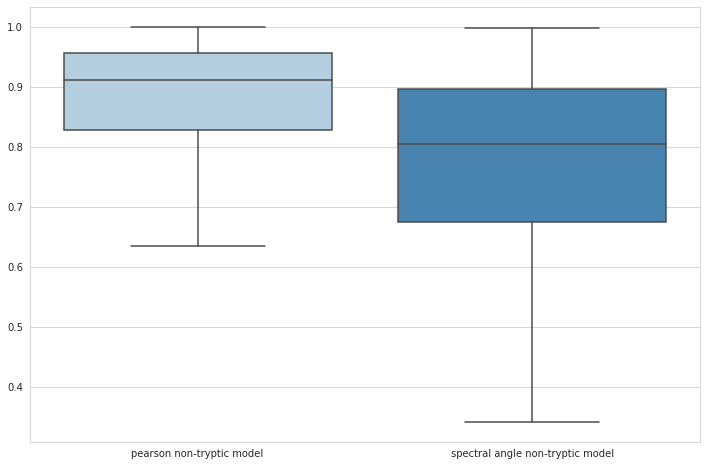

In [87]:
plt.figure(figsize=(12, 8))
model_perf = pd.DataFrame(columns=["pearson non-tryptic model", "spectral angle non-tryptic model"])
model_perf["pearson non-tryptic model"] = pear_corr
model_perf["spectral angle non-tryptic model"] = spec_corr
sns.set_style("whitegrid")
ax = sns.boxplot(data = model_perf, palette="Blues",showfliers = False)


plt.show()

# Performance eval of different in depth models 

In [88]:
tryptic_vectors, tryptic_targets, tryptic_psmids = load_data("data/tryptic_test_vector.pkl", "B")
non_tryptic_vectors, non_tryptic_targets, non_tryptic_psmids = load_data("data/non_tryptic_test_vector.pkl", "B")

In [89]:
tryptic_test = xgb.DMatrix(tryptic_vectors, label=tryptic_targets)
non_tryptic_test = xgb.DMatrix(non_tryptic_vectors, label=non_tryptic_targets)

In [90]:
predictions_tryptic = bst2.predict(tryptic_test)
predictions_non_tryptic = bst2.predict(non_tryptic_test)

In [91]:
New_model_perf.head()

,pearson correlation,spectral angle,type,Model
0,0.962964,0.972758,tryptic,new model
1,0.884992,0.754628,tryptic,new model
2,0.972640,0.861468,tryptic,new model
3,0.928428,0.781455,tryptic,new model
4,0.974027,0.814760,tryptic,new model


In [92]:
tryptic_test_LC = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
tryptic_new_model = Scorer(tryptic_psmids)
tryptic_test_LC["pearson correlation"], tryptic_test_LC["spectral angle"] = tryptic_new_model.psm_score(tryptic_targets,predictions_tryptic)
tryptic_test_LC["type"] = "tryptic"

non_tryptic_test_LC = pd.DataFrame(columns = ["pearson correlation", "spectral angle"])
non_tryptic_new_model = Scorer(non_tryptic_psmids)
non_tryptic_test_LC["pearson correlation"], non_tryptic_test_LC["spectral angle"] = non_tryptic_new_model.psm_score(non_tryptic_targets,predictions_non_tryptic)
non_tryptic_test_LC["type"] = "non-tryptic"

less_complex_model_perf = pd.concat([tryptic_test_LC, non_tryptic_test_LC])
less_complex_model_perf["Model"] = "Less complex model"

/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [93]:
model_comparison_complexity = pd.concat([New_model_perf,less_complex_model_perf ])

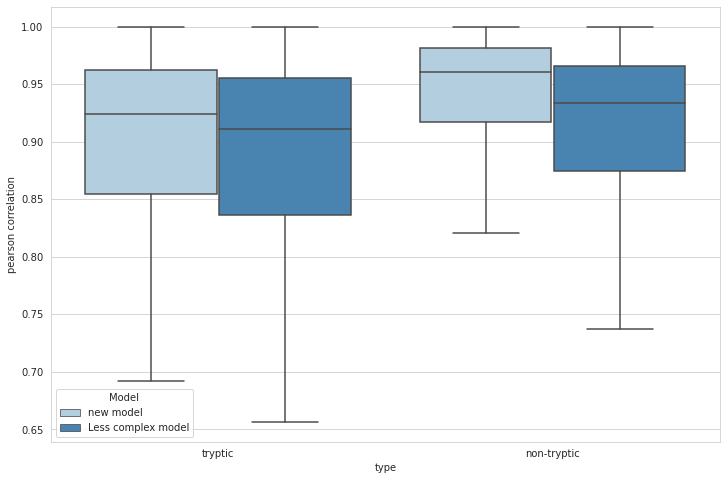

In [94]:
plt.figure(figsize=(12, 8))
sns.boxplot(data = model_comparison_complexity, x="type", y="pearson correlation",hue="Model", palette="Blues", showfliers = False)
plt.show()